Author: Matt Mollison

Date: 2016-08-27

Project: Code For San Francisco, CA Department of Justice, juvenile arrests/felonies

NB:
- This analysis only examines 2009 arrests
- This is an initial analysis and is not ready for presentation to a wider audience
    - Recommend distilling current results and reviewing with stakeholder
- Clarification about this prompt is recommended, as discussed below in the **Analysis Assessment** section


# Objective

Prompt 3: Statewide, what contextual and ethnic factors best predict the arrest of juveniles for felonies?

I think this question should be better specified. More on this below in the **Analysis Assessment** section

# Data sets

- `ca_county_agency_contextual_indicators_2009-2014_05-03-2016.csv`
- `ca_county_population_by_race_gender_age_2005-2014_02-05-2016.csv`
- `offense_codes.csv`
- `arrest data: ca_doj_arrests_deidentified_2000-2014_05-07-2016/ca_doj_arrests_deidentified_*.csv`

# Arrest records data description

## Crime-related data

### Offense level

The three types of arrests (coded by the `offense_level` field) are `'felony'`, `'misdemeanor'`, and `'status offense'`.

Felonies and misdemeanors are obviously very different classes of offenses. The crimes involved in a felony include burglary, vandalism, weapon possession, more serious battery, and murder. The crimes involved in a misdemeanor include petty theft, less serious battery, and disturbances.

A `'status offense'` only occurs for `age_group=='juvenile'` cases. It is not defined anywhere in the provided documents, but according to Wikipedia https://en.wikipedia.org/wiki/Status_offense it likely means that it is a crime that can only be committed by juveniles (e.g., possession of a firearm *by a minor*).

### Status type

The `status_type` field represents what happens after the initial point of contact: `'booked'`, `'cited'`, `'other'`. `'booked'` means the person goes through a formal booking process (this might entail getting fingerprinted and put in jail). `'cited'` means the person is cited and released. There was no information provided about what it means to be cited and released, but searching online seems to imply that the person may still undergo court action and could still be formally arrested at a later point. It's possible that when a person is cited and released, the crime is less serious (it's still a felony if `offense_level=='felony'`), but there may be factors that play into one or the other. **It is unknown what `'other'` means.**

### Disposition

The `disposition` field seems to represent what happens after the arrest.

- `'referred to juvenile probation department'` (juvenile felony, juvenile misdemeanor, juvenile status offense)
- `'handled within department'` (juvenile felony, juvenile misdemeanor, juvenile status offense)
- `'turned over to other agency'` (juvenile felony, juvenile misdemeanor, juvenile status offense, adult felony, adult misdemeanor)
- `'felony complaint sought'` (adult felony)
- `'misdemeanor complaint sought'` (adult felony, adult misdemeanor)
- `'released'` (adult felony, adult misdemeanor)

## Personal data

### Age group

- `'juvenile'`
- `'adult'`

### Gender

- `'male'`
- `'female'`

### Race or ethnicity

- `'Hispanic'`
- `'White'`
- `'suppressed_due_to_privacy_concern'`
- `'Black'`
- `'Other'`
- `'Asian/Pacific Islander'`

# Analysis assessment

The prompt asks about the factors that predict arrests of juveniles for felonies. It's unclear which is the proper way to slice the data to answer this question.

### Felony vs. misdemeanor (`offense_level`)

One way to examine juvenile felonies is to compare them to misdemeanors. However, this may not be an appropriate comparison because these categories consist of very different types of crimes. Additionally, care must be taken when interpreting such results because it could lead to the conclusion that a race or gender is more likely to commit a felony compared to a misdemeanor, which surely would be a false claim. Whether a record exist for someone may be a function of the police officer(s) who made the arrest, and not purely the arrestee.

For felonies, there are more bookings than citations. For misdemeanors, there are more citations than bookings. It might make sense to only look at `status_type=='booked'` if comparing these types of crimes.

### Booked vs. cited (`status_type`)

Maybe it makes more sense to understand what happens after the initial point of contact (i.e., at the arrest) using the `status_type` field. This would ask about who is more likely to be booked compared to being cited and released. Data would be limited to `age_group=='juvenile'` and `offense_level=='felony'`.

It would be interesting to separate the most prevalent types of felonies, and examine the factors for each that are correlated with who gets booked and who gets cited. The fields `bcs_offense_code` or `bcs_summary_offence_code` code the type of felony. `bcs_offense_code` seems to provide more cohesive groups of crimes, meaning they have more in common with each other than crimes grouped by `bcs_summary_offence_code`.

An example exploration: Plot proportion of race for a given felony offense code showing who is booked vs cited.

### Creating a non-arrest group

I'm not sure that it makes sense to simply ask what is different about the juveniles who get arrested for felonies when there's no representation in the data set of those who do not get arrested for those crimes. Is it possible to create rows in the dataset based on the juvenile population numbers of each race and gender for each county? It seems likely that felony arrests would become an extreme minority compared to non-arrest "records"; such an imbalanced data set could be difficult to classify.

## Offense descriptions

Unfortunately, we have to mostly ignore `offense_codes.csv` for now, as there are multiple row matches when joining with arrests on `bcs_offense_code` or `bcs_summary_offence_code`. This is also true when joining to arrests on both of these fields together (using the `and` operator). Even with the `hierarchy` and `code_section` fields there are not unique row values to pull out a single offense `description`. The best thing we can do for now is look at a significantly impactful `bcs_offense_code` or `bcs_summary_offence_code` after analyzing the important factors and try to understand what type of offense it might be (see the inline function `get_sorted_title_offense()`).

NB: There were a few rows in `offense_codes.csv` that contained commas in the `description` field that I had to fix manually in order to read, and saved this file as `offense_codes_v2.csv`. These were line numbers 975, 2460, and 2461; the field values simply needed quotes around them.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

# from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np

import re

from calendar import isleap

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

In [2]:
import os
import sys
sys.path.append(os.path.join(os.getenv('HOME'),'src','python'))
import classify_utils as cu

# Load the data and create features

In [3]:
# Load contextual indicators

# df_ctx = pd.read_csv('ca_county_agency_contextual_indicators_2009-2014_05-03-2016.csv', parse_dates=['year'])
df_ctx = pd.read_csv('ca_county_agency_contextual_indicators_2009-2014_05-03-2016.csv')
df_ctx = df_ctx.set_index('year')
# df_ctx.index = df_ctx.index.to_period(freq='A')

In [4]:
df_ctx.head()

,county,agency_name,agency_code,less_than_high_school,high_school_or_higher,bachelors_or_higher,per_capita_income,median_income,poverty_rate,employment_rate,unemployment_rate
year,,,,,,,,,,,
2009,Alameda,All Combined,All Combined,14.10000,85.70000,39.90000,33831.00000,68863.00000,23.40000,61.60000,7.70000
2009,Alameda,Alameda Police Department,0101,9.00000,91.10000,45.40000,38809.00000,73503.00000,17.90000,62.40000,7.00000
2009,Alameda,Albany Police Department,0102,6.20000,94.80000,69.80000,35982.00000,72516.00000,18.90000,65.40000,5.10000
2009,Alameda,Berkeley Police Department,0103,2.70000,93.60000,67.40000,36798.00000,59097.00000,24.50000,56.30000,6.70000
2009,Alameda,Dublin Police Department,0130,17.10000,91.00000,43.10000,40092.00000,108711.00000,22.40000,61.20000,6.00000


In [5]:
df_ctx.columns

Index(['county', 'agency_name', 'agency_code', 'less_than_high_school',
       'high_school_or_higher', 'bachelors_or_higher', 'per_capita_income',
       'median_income', 'poverty_rate', 'employment_rate',
       'unemployment_rate'],
      dtype='object')

In [6]:
# Load county population

# df_pop = pd.read_csv('ca_county_population_by_race_gender_age_2005-2014_02-05-2016.csv', parse_dates=['year'])
df_pop = pd.read_csv('ca_county_population_by_race_gender_age_2005-2014_02-05-2016.csv')
df_pop = df_pop.set_index('year')
df_pop = df_pop.ix['2009':]
# df_pop.index = df_pop.index.to_period(freq='A')

In [7]:
df_pop['gender'].unique()

array(['All Combined', 'Female', 'Male'], dtype=object)

In [8]:
df_pop.head(5)

,county,race,gender,age_group,population
year,,,,,
2009,Alameda,All Combined,All Combined,All Combined,1503827
2009,Alameda,All Combined,All Combined,Juvenile,342207
2009,Alameda,All Combined,All Combined,Adult,1161620
2009,Alameda,All Combined,All Combined,0-9,193020
2009,Alameda,All Combined,All Combined,10-14,91066


In [9]:
# get only the 'All Combined' rows, combining the agencies for each county
df_ctx_combo = df_ctx[df_ctx['agency_code'] == 'All Combined']

# drop these columns because they all contain the same values
df_ctx_combo = df_ctx_combo.drop(['agency_name', 'agency_code'], axis=1)
# make a multiindex
df_ctx_combo = df_ctx_combo.set_index('county', append=True)

df_ctx_combo.head()

less_than_high_school  high_school_or_higher  \
year county                                                    
2009 Alameda                 14.10000               85.70000   
     Alpine                  35.20000               91.20000   
     Amador                  28.10000               87.30000   
     Butte                    9.20000               85.90000   
     Calaveras               13.60000               89.40000   

                bachelors_or_higher  per_capita_income  median_income  \
year county                                                             
2009 Alameda               39.90000        33831.00000    68863.00000   
     Alpine                26.80000        30436.00000    54605.00000   
     Amador                19.50000        26532.00000    57347.00000   
     Butte                 24.80000        22904.00000    42002.00000   
     Calaveras             19.30000        27728.00000    57676.00000   

                poverty_rate  employment_rate  unemployment_rate  
year county                                                       
2009 Alameda        23.40000         61.60000            7.70000  
     Alpine         27.40000         58.50000           15.20000  
     Amador         22.90000         44.90000           10.40000  
     Butte          21.70000         51.60000           10.60000  
     Calaveras      30.90000         50.60000            8.20000

In [10]:
# get per-county 'All Combined' rows of population data, to join to the contextual data
df_pop_combo = df_pop[(df_pop['county'] != 'All Combined') &
                      (df_pop['race'] == 'All Combined') &
                      (df_pop['gender'] == 'All Combined') &
                      (df_pop['age_group'] == 'All Combined')]

# drop these columns because we're using 'All Combined'
df_pop_combo = df_pop_combo.drop(['race', 'gender', 'age_group'], axis=1)
# make a multiindex so we can join them
df_pop_combo = df_pop_combo.set_index('county', append=True)

In [11]:
# create features for: population proportion of county by age, gender, race

# not sure whether these will be useful, just exploratory

ages = ['Adult', 'Juvenile']
for age in ages:
    df_this_pop = pd.DataFrame()
    df_this_pop = df_pop[(df_pop['county'] != 'All Combined') &
                          (df_pop['race'] == 'All Combined') &
                          (df_pop['gender'] == 'All Combined') &
                          (df_pop['age_group'] == age)].drop(['race', 'gender', 'age_group'], axis=1).set_index('county', append=True)
    col_str = 'prop_age_{}'.format(age)
    df_this_pop = df_this_pop.rename(columns={'population': col_str})
    df_this_pop[col_str] = df_this_pop[col_str] / df_pop_combo['population']
    
    # join it with the larger df
    df_pop_combo = df_pop_combo.merge(df_this_pop, how='left', left_index=True, right_index=True)

genders = ['Female', 'Male']
for gender in genders:
    df_this_pop = df_pop[(df_pop['county'] != 'All Combined') &
                          (df_pop['race'] == 'All Combined') &
                          (df_pop['gender'] == gender) &
                          (df_pop['age_group'] == 'All Combined')].drop(['race', 'gender', 'age_group'], axis=1).set_index('county', append=True)
    col_str = 'prop_gender_{}'.format(gender)
    df_this_pop = df_this_pop.rename(columns={'population': col_str})
    df_this_pop[col_str] = df_this_pop[col_str] / df_pop_combo['population']
    
    # join it with the larger df
    df_pop_combo = df_pop_combo.join(df_this_pop, how='left')

races = ['Hispanic', 'Black', 'White', 'Asian/Pacific Islander', 'Native American', 'Other']
for race in races:
    if race == 'Asian/Pacific Islander':
        race_str = 'Asian_PI'
    elif race == 'Native American':
        race_str = 'Native_American'
    else:
        race_str = race
    df_this_pop = df_pop[(df_pop['county'] != 'All Combined') &
                          (df_pop['race'] == race) &
                          (df_pop['gender'] == 'All Combined') &
                          (df_pop['age_group'] == 'All Combined')].drop(['race', 'gender', 'age_group'], axis=1).set_index('county', append=True)
    col_str = 'prop_race_{}'.format(race_str)
    df_this_pop = df_this_pop.rename(columns={'population': col_str})
    df_this_pop[col_str] = df_this_pop[col_str] / df_pop_combo['population']
    
    # join it with the larger df
    df_pop_combo = df_pop_combo.join(df_this_pop, how='left')

In [12]:
df_pop_combo.head()

population  prop_age_Adult  prop_age_Juvenile  \
year county                                                     
2009 Alameda       1503827         0.77244            0.22756   
     Alpine           1178         0.78523            0.21477   
     Amador          37905         0.82424            0.17576   
     Butte          219287         0.79783            0.20217   
     Calaveras       45563         0.79494            0.20506   

                prop_gender_Female  prop_gender_Male  prop_race_Hispanic  \
year county                                                                
2009 Alameda               0.50920           0.49080             0.22272   
     Alpine                0.48302           0.51698             0.07216   
     Amador                0.45371           0.54629             0.12128   
     Butte                 0.50604           0.49396             0.13549   
     Calaveras             0.50034           0.49966             0.09804   

                prop_race_Black  prop_race_White  prop_race_Asian_PI  \
year county                                                            
2009 Alameda            0.12551          0.34932             0.26274   
     Alpine             0.00000          0.72581             0.00594   
     Amador             0.02865          0.79963             0.01235   
     Butte              0.01430          0.76093             0.04194   
     Calaveras          0.00799          0.84233             0.01271   

                prop_race_Native_American  prop_race_Other  
year county                                                 
2009 Alameda                      0.00288          0.03684  
     Alpine                       0.17827          0.01783  
     Amador                       0.01477          0.02330  
     Butte                        0.01619          0.03117  
     Calaveras                    0.01258          0.02636

In [13]:
df_ctx_pop_county = df_ctx_combo.join(df_pop_combo, how='left')

In [14]:
df_ctx_pop_county.head()

less_than_high_school  high_school_or_higher  \
year county                                                    
2009 Alameda                 14.10000               85.70000   
     Alpine                  35.20000               91.20000   
     Amador                  28.10000               87.30000   
     Butte                    9.20000               85.90000   
     Calaveras               13.60000               89.40000   

                bachelors_or_higher  per_capita_income  median_income  \
year county                                                             
2009 Alameda               39.90000        33831.00000    68863.00000   
     Alpine                26.80000        30436.00000    54605.00000   
     Amador                19.50000        26532.00000    57347.00000   
     Butte                 24.80000        22904.00000    42002.00000   
     Calaveras             19.30000        27728.00000    57676.00000   

                poverty_rate  employment_rate  unemployment_rate  population  \
year county                                                                    
2009 Alameda        23.40000         61.60000            7.70000     1503827   
     Alpine         27.40000         58.50000           15.20000        1178   
     Amador         22.90000         44.90000           10.40000       37905   
     Butte          21.70000         51.60000           10.60000      219287   
     Calaveras      30.90000         50.60000            8.20000       45563   

                prop_age_Adult  prop_age_Juvenile  prop_gender_Female  \
year county                                                             
2009 Alameda           0.77244            0.22756             0.50920   
     Alpine            0.78523            0.21477             0.48302   
     Amador            0.82424            0.17576             0.45371   
     Butte             0.79783            0.20217             0.50604   
     Calaveras         0.79494            0.20506             0.50034   

                prop_gender_Male  prop_race_Hispanic  prop_race_Black  \
year county                                                             
2009 Alameda             0.49080             0.22272          0.12551   
     Alpine              0.51698             0.07216          0.00000   
     Amador              0.54629             0.12128          0.02865   
     Butte               0.49396             0.13549          0.01430   
     Calaveras           0.49966             0.09804          0.00799   

                prop_race_White  prop_race_Asian_PI  \
year county                                           
2009 Alameda            0.34932             0.26274   
     Alpine             0.72581             0.00594   
     Amador             0.79963             0.01235   
     Butte              0.76093             0.04194   
     Calaveras          0.84233             0.01271   

                prop_race_Native_American  prop_race_Other  
year county                                                 
2009 Alameda                      0.00288          0.03684  
     Alpine                       0.17827          0.01783  
     Amador                       0.01477          0.02330  
     Butte                        0.01619          0.03117  
     Calaveras                    0.01258          0.02636

In [15]:
# old, not using

# create a state-level view of contextual factors

# # determine the number of people in each county for these columns based on percentage columns and population
# cols = ['less_than_high_school', 'high_school_or_higher', 'bachelors_or_higher',
#         'poverty_rate', 'employment_rate', 'unemployment_rate']

# new_cols = ['population', 'county_income']
# for col in cols:
#     new_col = 'n_{}'.format(col)
#     new_cols.append(new_col)
#     df_ctx_pop_county[new_col] = df_ctx_pop_county[col] * 0.01 * df_ctx_pop_county['population']

# # set up how to aggregate
# agg = {}
# for new_col in new_cols:
#     agg[new_col] = 'sum'
# agg['median_income'] = 'mean'

# # income of the county
# df_ctx_pop_county['county_income'] = df_ctx_pop_county['per_capita_income'] * df_ctx_pop_county['population']

# # get state-level info by grouping all the counties together
# df_ctx_pop_state = df_ctx_pop_county.groupby(level=[0])[new_cols].agg(agg)

# # drop the new columns, except population, because we're going to try joining this to arrests
# df_ctx_pop_county = df_ctx_pop_county.drop([x for x in new_cols if x != 'population'], axis=1)

In [16]:
# # turn state numbers into percentages
# for new_col in [x for x in new_cols if x != 'population']:
#     if new_col != 'county_income':
#         col = new_col.replace('n_', '')
#         df_ctx_pop_state[col] = (df_ctx_pop_state[new_col] / df_ctx_pop_state['population']) * 100
#     else:
#         df_ctx_pop_state['per_capita_income'] = (df_ctx_pop_state[new_col] / df_ctx_pop_state['population'])

# # keep only these columns
# keep_cols = ['population', 'per_capita_income', 'median_income',
#              'less_thahigh_school', 'high_school_or_higher', 'bachelors_or_higher',
#              'poverty_rate', 'employment_rate', 'unemployment_rate']
# df_ctx_pop_state = df_ctx_pop_state[keep_cols]

In [17]:
# df_ctx_pop_state.head()

In [18]:
# Load the fixed offense codes file

df_off = pd.read_csv('offense_codes_v2.csv', quotechar='"')
df_off.head()

,bcs_summary_offence_code,bcs_offense_code,hierarchy,offense_level,code_section,code_type,description,possible_sentence
0,60,96,141800,M,20,VC,USE/ETC FALSE INFORMATION/ETC ON DOCUMENTS TO ...,1-180 DA JAIL
1,60,96,141600,M,27,VC,IMPERSONATE CHP OFFICER,1-180 DA JAIL
2,60,96,162600,M,31,VC,GIVE FALSE INFORMATION TO PEACE OFFICER,1-180 DA JAIL
3,25,900,68600,F,32,PC,ACCESSORY,"16 MO,2,3 YRS OR J"
4,60,96,92600,M,32,PC,ACCESSORY:PER 33 PC,1-365 DA JAIL


In [19]:
# Load the arrests for a given year
dtype={'county': str, 'agency_name': str, 'agency_code': str,
       'arrest_year': int, 'arrest_month': int, 'arrest_day': int,
       'race_or_ethnicity': str, 'gender': str, 'age_group': str,
       'summary_offense_level': str,'offense_level': str,'bcs_offense_code': int,
       'bcs_summary_offence_code': int,'fbi_offense_code': str,'status_type': str,
       'disposition': str}

# for year in pd.period_range(start='2009', end='2014', freq='A'):
year = '2009'

filename = 'ca_doj_arrests_deidentified_2000-2014_05-07-2016/ca_doj_arrests_deidentified_{year}_05-07-2016.csv'.format(year=year)

df_arr = pd.read_csv(filename, dtype=dtype)

In [20]:
df_arr.head()

,county,agency_name,agency_code,arrest_year,arrest_month,arrest_day,race_or_ethnicity,gender,age_group,summary_offense_level,offense_level,bcs_offense_code,bcs_summary_offence_code,fbi_offense_code,status_type,disposition
0,Alameda,Alameda Co. Sheriff's Department,0100,2009,1,1,Black,male,adult,misdemeanor,misdemeanor,856,51,21,booked,misdemeanor complaint sought
1,Alameda,Alameda Co. Sheriff's Department,0100,2009,1,1,Black,male,adult,misdemeanor,misdemeanor,856,51,21,booked,misdemeanor complaint sought
2,Alameda,Alameda Co. Sheriff's Department,0100,2009,1,1,Hispanic,male,adult,misdemeanor,misdemeanor,856,51,21,booked,misdemeanor complaint sought
3,Alameda,Alameda Co. Sheriff's Department,0100,2009,1,1,Hispanic,male,adult,misdemeanor,misdemeanor,856,51,21,booked,misdemeanor complaint sought
4,Alameda,Alameda Co. Sheriff's Department,0100,2009,1,1,Black,male,adult,misdemeanor,misdemeanor,856,51,21,booked,misdemeanor complaint sought


In [21]:
df_arr['age_group'].value_counts()

adult       1262156
juvenile     204696
Name: age_group, dtype: int64

In [22]:
df_arr['gender'].value_counts()

male      1138107
female     328745
Name: gender, dtype: int64

In [23]:
df_arr['race_or_ethnicity'].value_counts()

Hispanic                             468921
White                                367242
suppressed_due_to_privacy_concern    325125
Black                                230000
Other                                 38018
Asian/Pacific Islander                37546
Name: race_or_ethnicity, dtype: int64

In [24]:
# shorten race strings
df_arr.loc[df_arr['race_or_ethnicity'] == 'suppressed_due_to_privacy_concern', 'race_or_ethnicity'] = 'suppressed'
df_arr.loc[df_arr['race_or_ethnicity'] == 'Asian/Pacific Islander', 'race_or_ethnicity'] = 'Asian_PI'

# Start exploring the data

In [25]:
df_arr[df_arr['age_group'] == 'juvenile']['offense_level'].value_counts()

misdemeanor       115951
felony             58555
status offense     30190
Name: offense_level, dtype: int64

In [26]:
# overall, juveniles are cited and released a lot more than adults
# (they probably commit different types of crimes)

print('overall')
print(df_arr[(df_arr['age_group'] == 'juvenile')]['status_type'].value_counts().sort_index())
print(df_arr[(df_arr['age_group'] == 'adult')]['status_type'].value_counts().sort_index())

print('\nfelony')
print(df_arr[(df_arr['age_group'] == 'juvenile') & (df_arr['offense_level'] == 'felony')]['status_type'].value_counts().sort_index())
print(df_arr[(df_arr['age_group'] == 'adult') & (df_arr['offense_level'] == 'felony')]['status_type'].value_counts().sort_index())

print('\nmisdemeanor')
print(df_arr[(df_arr['age_group'] == 'juvenile') & (df_arr['offense_level'] == 'misdemeanor')]['status_type'].value_counts().sort_index())
print(df_arr[(df_arr['age_group'] == 'adult') & (df_arr['offense_level'] == 'misdemeanor')]['status_type'].value_counts().sort_index())


overall
booked    80597
cited     93256
other     30843
Name: status_type, dtype: int64
booked    987591
cited     242553
other      32012
Name: status_type, dtype: int64

felony
booked    41868
cited      9830
other      6857
Name: status_type, dtype: int64
booked    393602
cited       4181
other      10103
Name: status_type, dtype: int64

misdemeanor
booked    35444
cited     63852
other     16655
Name: status_type, dtype: int64
booked    593989
cited     238372
other      21909
Name: status_type, dtype: int64


In [27]:
# juvenile felonies lead to bookings at a much higher rate than misdemeanors
# (makes sense, they're quite different crimes)

print(df_arr[(df_arr['age_group'] == 'juvenile') & (df_arr['offense_level'] == 'felony')]['status_type'].value_counts().sort_index())

print(df_arr[(df_arr['age_group'] == 'juvenile') & (df_arr['offense_level'] == 'misdemeanor')]['status_type'].value_counts().sort_index())

booked    41868
cited      9830
other      6857
Name: status_type, dtype: int64
booked    35444
cited     63852
other     16655
Name: status_type, dtype: int64


In [28]:
print(df_arr[(df_arr['age_group'] == 'juvenile') & (df_arr['offense_level'] == 'felony')]['disposition'].value_counts().sort_index())
print(df_arr[(df_arr['age_group'] == 'juvenile') & (df_arr['offense_level'] == 'misdemeanor')]['disposition'].value_counts().sort_index())
print(df_arr[(df_arr['age_group'] == 'juvenile') & (df_arr['offense_level'] == 'status offense')]['disposition'].value_counts().sort_index())


handled within department                     4658
referred to juvenile probation department    52803
turned over to other agency                   1094
Name: disposition, dtype: int64
handled within department                    20419
referred to juvenile probation department    93783
turned over to other agency                   1749
Name: disposition, dtype: int64
handled within department                    14735
referred to juvenile probation department    15122
turned over to other agency                    333
Name: disposition, dtype: int64


In [29]:
# fix wonky dates

# fix rows with arrest_day == 0
df_arr.loc[(df_arr['arrest_day'] == 0), 'arrest_day'] = 1

# fix months with 30 days that have arrest_day == 31
month_30 = [4, 6, 9, 11]
for month in month_30:
    df_arr.loc[(df_arr['arrest_month'] == month) & (df_arr['arrest_day'] == 31), 'arrest_day'] = 30

# Roll February arrest_day past 28 (i.e., 29, 30, 31) or 29th (i.e., 30, 31) back to max number of days
df_arr.loc[(df_arr['arrest_year'].apply(lambda x: isleap(x))) & (df_arr['arrest_month'] == 2) & (df_arr['arrest_day'] > 29), 'arrest_day'] = 29
df_arr.loc[~(df_arr['arrest_year'].apply(lambda x: isleap(x))) & (df_arr['arrest_month'] == 2) & (df_arr['arrest_day'] > 28), 'arrest_day'] = 28

In [30]:
# # Convert to datetime
# df_arr['arrest_year'] = df_arr['arrest_year'].astype(str)
# df_arr['arrest_month'] = df_arr['arrest_month'].apply(lambda x: '{:02d}'.format(x))
# df_arr['arrest_day'] = df_arr['arrest_day'].apply(lambda x: '{:02d}'.format(x))
# df_arr['arrest_date'] = df_arr[['arrest_year', 'arrest_month', 'arrest_day']].apply(lambda x: pd.Timestamp('-'.join(x)), axis=1)

df_arr['arrest_date'] = pd.to_datetime(df_arr['arrest_year']*10000 + df_arr['arrest_month']*100 + df_arr['arrest_day'], format="%Y%m%d")

# drop the columns for assembling the date
df_arr = df_arr.drop(['arrest_year', 'arrest_month', 'arrest_day'], axis=1)

df_arr = df_arr.set_index('arrest_date')

In [31]:
# limit using the criteria for this question

df_fel = df_arr[(df_arr['age_group'] == 'juvenile') &
                (df_arr['offense_level'] == 'felony')
               ]
print(df_fel.shape)

(58555, 13)


## Find the most prevalent offense codes

In [32]:
df_fel['bcs_summary_offence_code'].value_counts().head(10)

8     13695
6      8649
25     8169
5      6232
19     5426
9      5194
10     2948
13     2104
14     1938
12     1503
Name: bcs_summary_offence_code, dtype: int64

In [33]:
df_fel['bcs_offense_code'].value_counts().head(10)

400    10952
64      4970
844     4944
200     4462
320     3326
570     2744
530     2545
345     2163
501     1737
342     1649
Name: bcs_offense_code, dtype: int64

In [34]:
# investigate some of the top offenses
df_off[df_off['bcs_offense_code'] == 400].head()

,bcs_summary_offence_code,bcs_offense_code,hierarchy,offense_level,code_section,code_type,description,possible_sentence
987,8,400,12900,F,459,PC,BURGLARY,"2,4,6 YRS"
992,8,400,42700,F,459.5,PC,SHOPLIFTING,"16 MO,2,3 YRS"


In [35]:
# investigate some of the top offenses
df_off[df_off['bcs_summary_offence_code'] == 6].head()

,bcs_summary_offence_code,bcs_offense_code,hierarchy,offense_level,code_section,code_type,description,possible_sentence
11,6,345,37300,F,69,PC,OBSTRUCT/RESIST EXECUTIVE OFFICER,"16 MO,2,3 YRS OR J"
14,6,345,40500,F,71,PC,THREATEN SCHOOL/PUBLIC OFFICER/EMPLOYEE,"16 MO,2,3 YRS OR J"
20,6,345,40100,F,76 (A),PC,THREATEN/ETC ELECTED OFFICIAL/JUDGE/ETC,"16 MO,2,3 YRS OR J"
30,6,345,40410,F,95.1,PC,THREATEN JUROR AFTER VERDICT IS RENDERED,"16 MO,2,3 YRS OR J"
89,6,345,22510,F,139 (A),PC,FELON THREATEN TO USE FORCE/ETC ON WITNESS/ETC,"2,3,4 YRS OR J"


In [36]:
# add the county contextual numbers to the felony data frame
df_fel.loc[:, 'year'] = df_fel.index.year

df_fel = df_fel.merge(df_ctx_pop_county, how='left', left_on=['year', 'county'], right_index=True)

df_fel = df_fel.drop(['year'], axis=1)

/Users/mattmollison/miniconda3/envs/py3/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mattmollison/miniconda3/envs/py3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [37]:
# code the outcome variable
df_fel.loc[:, 'booked'] = np.nan
df_fel.loc[(df_fel['status_type'] == 'booked'), 'booked'] = 1
df_fel.loc[(df_fel['status_type'] == 'cited'), 'booked'] = 0
# df_fel.loc[(df_fel['status_type'] == 'other'), 'booked'] = np.nan

In [38]:
# 81% of juvenile felony arrests are booked, vs cited and released

df_fel[(df_fel['booked'] == 0) | (df_fel['booked'] == 1)]['booked'].mean()

0.8098572478625866

In [39]:
df_fel.head()

,county,agency_name,agency_code,race_or_ethnicity,gender,age_group,summary_offense_level,offense_level,bcs_offense_code,bcs_summary_offence_code,fbi_offense_code,status_type,disposition,less_than_high_school,high_school_or_higher,bachelors_or_higher,per_capita_income,median_income,poverty_rate,employment_rate,unemployment_rate,population,prop_age_Adult,prop_age_Juvenile,prop_gender_Female,prop_gender_Male,prop_race_Hispanic,prop_race_Black,prop_race_White,prop_race_Asian_PI,prop_race_Native_American,prop_race_Other,booked
arrest_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-02,Alameda,Alameda Co. Sheriff's Department,0100,Hispanic,male,juvenile,juvenile,felony,844,19,15,booked,referred to juvenile probation department,14.10000,85.70000,39.90000,33831.00000,68863.00000,23.40000,61.60000,7.70000,1503827,0.77244,0.22756,0.50920,0.49080,0.22272,0.12551,0.34932,0.26274,0.00288,0.03684,1.00000
2009-01-04,Alameda,Alameda Co. Sheriff's Department,0100,Black,male,juvenile,juvenile,felony,64,25,14,booked,referred to juvenile probation department,14.10000,85.70000,39.90000,33831.00000,68863.00000,23.40000,61.60000,7.70000,1503827,0.77244,0.22756,0.50920,0.49080,0.22272,0.12551,0.34932,0.26274,0.00288,0.03684,1.00000
2009-01-04,Alameda,Alameda Co. Sheriff's Department,0100,Asian_PI,male,juvenile,juvenile,felony,300,6,04,booked,referred to juvenile probation department,14.10000,85.70000,39.90000,33831.00000,68863.00000,23.40000,61.60000,7.70000,1503827,0.77244,0.22756,0.50920,0.49080,0.22272,0.12551,0.34932,0.26274,0.00288,0.03684,1.00000
2009-01-13,Alameda,Alameda Co. Sheriff's Department,0100,Black,male,juvenile,juvenile,felony,530,9,13,booked,referred to juvenile probation department,14.10000,85.70000,39.90000,33831.00000,68863.00000,23.40000,61.60000,7.70000,1503827,0.77244,0.22756,0.50920,0.49080,0.22272,0.12551,0.34932,0.26274,0.00288,0.03684,1.00000
2009-01-13,Alameda,Alameda Co. Sheriff's Department,0100,Hispanic,male,juvenile,juvenile,felony,530,9,13,cited,referred to juvenile probation department,14.10000,85.70000,39.90000,33831.00000,68863.00000,23.40000,61.60000,7.70000,1503827,0.77244,0.22756,0.50920,0.49080,0.22272,0.12551,0.34932,0.26274,0.00288,0.03684,0.00000


In [40]:
df_fel.columns

Index(['county', 'agency_name', 'agency_code', 'race_or_ethnicity', 'gender',
       'age_group', 'summary_offense_level', 'offense_level',
       'bcs_offense_code', 'bcs_summary_offence_code', 'fbi_offense_code',
       'status_type', 'disposition', 'less_than_high_school',
       'high_school_or_higher', 'bachelors_or_higher', 'per_capita_income',
       'median_income', 'poverty_rate', 'employment_rate', 'unemployment_rate',
       'population', 'prop_age_Adult', 'prop_age_Juvenile',
       'prop_gender_Female', 'prop_gender_Male', 'prop_race_Hispanic',
       'prop_race_Black', 'prop_race_White', 'prop_race_Asian_PI',
       'prop_race_Native_American', 'prop_race_Other', 'booked'],
      dtype='object')

In [41]:
def get_sorted_title_offense(df_off, code, n_title_words=4):
    list_of_lists = df_off[df_off['bcs_offense_code'] == code]['description'].apply(lambda x: re.sub('[^A-Za-z]+', ' ', x).split()).values.tolist()
    lst = [val for sublist in list_of_lists for val in sublist]
    lst_sorted=sorted([ss for ss in set(lst) if len(ss)>3], 
                       key=lst.count, 
                       reverse=True)
    lst_sorted = [x for x in lst_sorted if x.upper() != 'ETC']
    title_str = ', '.join(lst_sorted[:n_title_words]).title()
    return title_str

## Plot most prevalent felony offenses by race and booked/cited/other

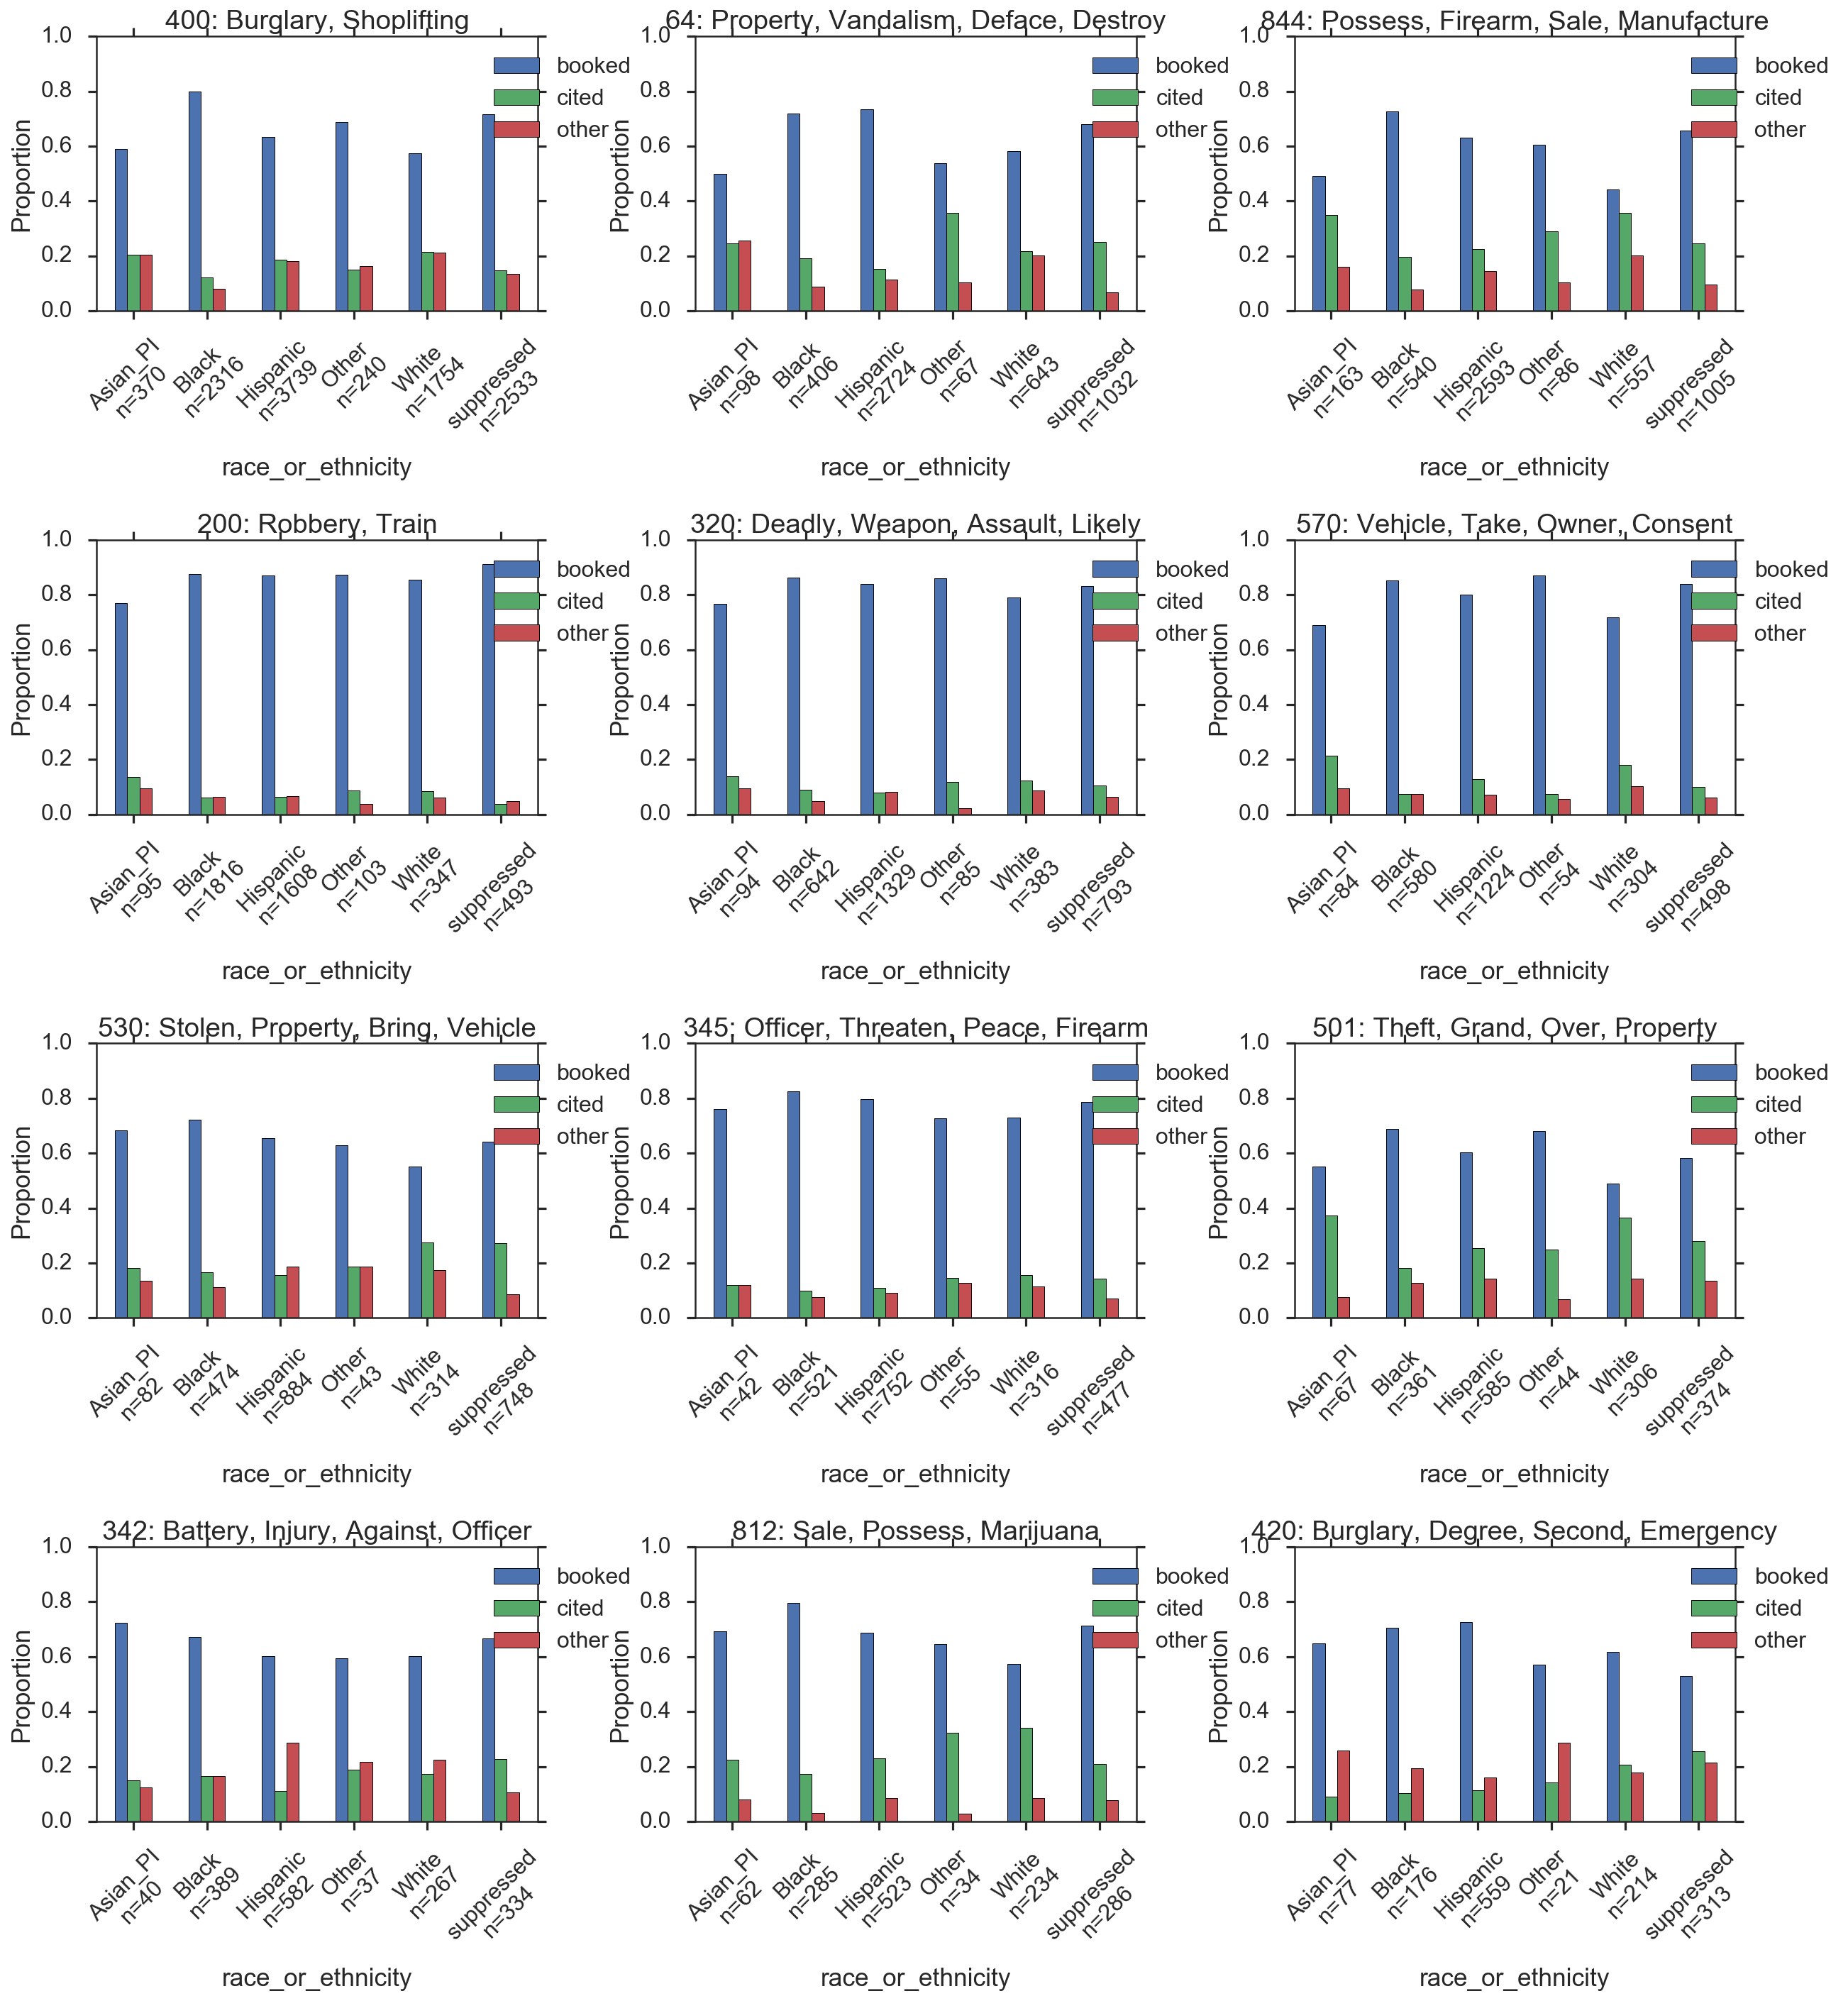

In [42]:
n_codes = 12

n_title_words=4

ncols=3
nrows=int(np.ceil(n_codes / ncols))

field = 'race_or_ethnicity'

fig, (axes) = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 5*nrows))

for ax, code in zip(axes.flat, df_fel['bcs_offense_code'].value_counts().head(n_codes).index.tolist()):
    code_count = df_fel[df_fel['bcs_offense_code'] == code].groupby(by=[field, 'status_type']).size()
    race_count = df_fel[df_fel['bcs_offense_code'] == code].groupby(by=[field]).size()

    prop_race = pd.DataFrame(code_count / race_count).unstack()[0]
    #prop_race = prop_race.sort_values(by='booked', ascending=False)

    title_str = get_sorted_title_offense(df_off, code, n_title_words=n_title_words)

    prop_race.plot(ax=ax, kind='bar');
    
    xlabels = ['{r}\nn={n}'.format(r=x.get_text(), n=race_count[x.get_text()]) for x in ax.get_xticklabels()]
    ax.set_xticklabels(xlabels, rotation=45)
    
    ax.set_ylim((0, 1));
    ax.set_ylabel('Proportion');
    ax.set_title('{c}: {t}'.format(c=code,t=title_str));
    ax.legend(bbox_to_anchor=(1.26, 1.0));
    
fig.tight_layout();

## Plot most prevalent felony offenses by gender and booked/cited/other

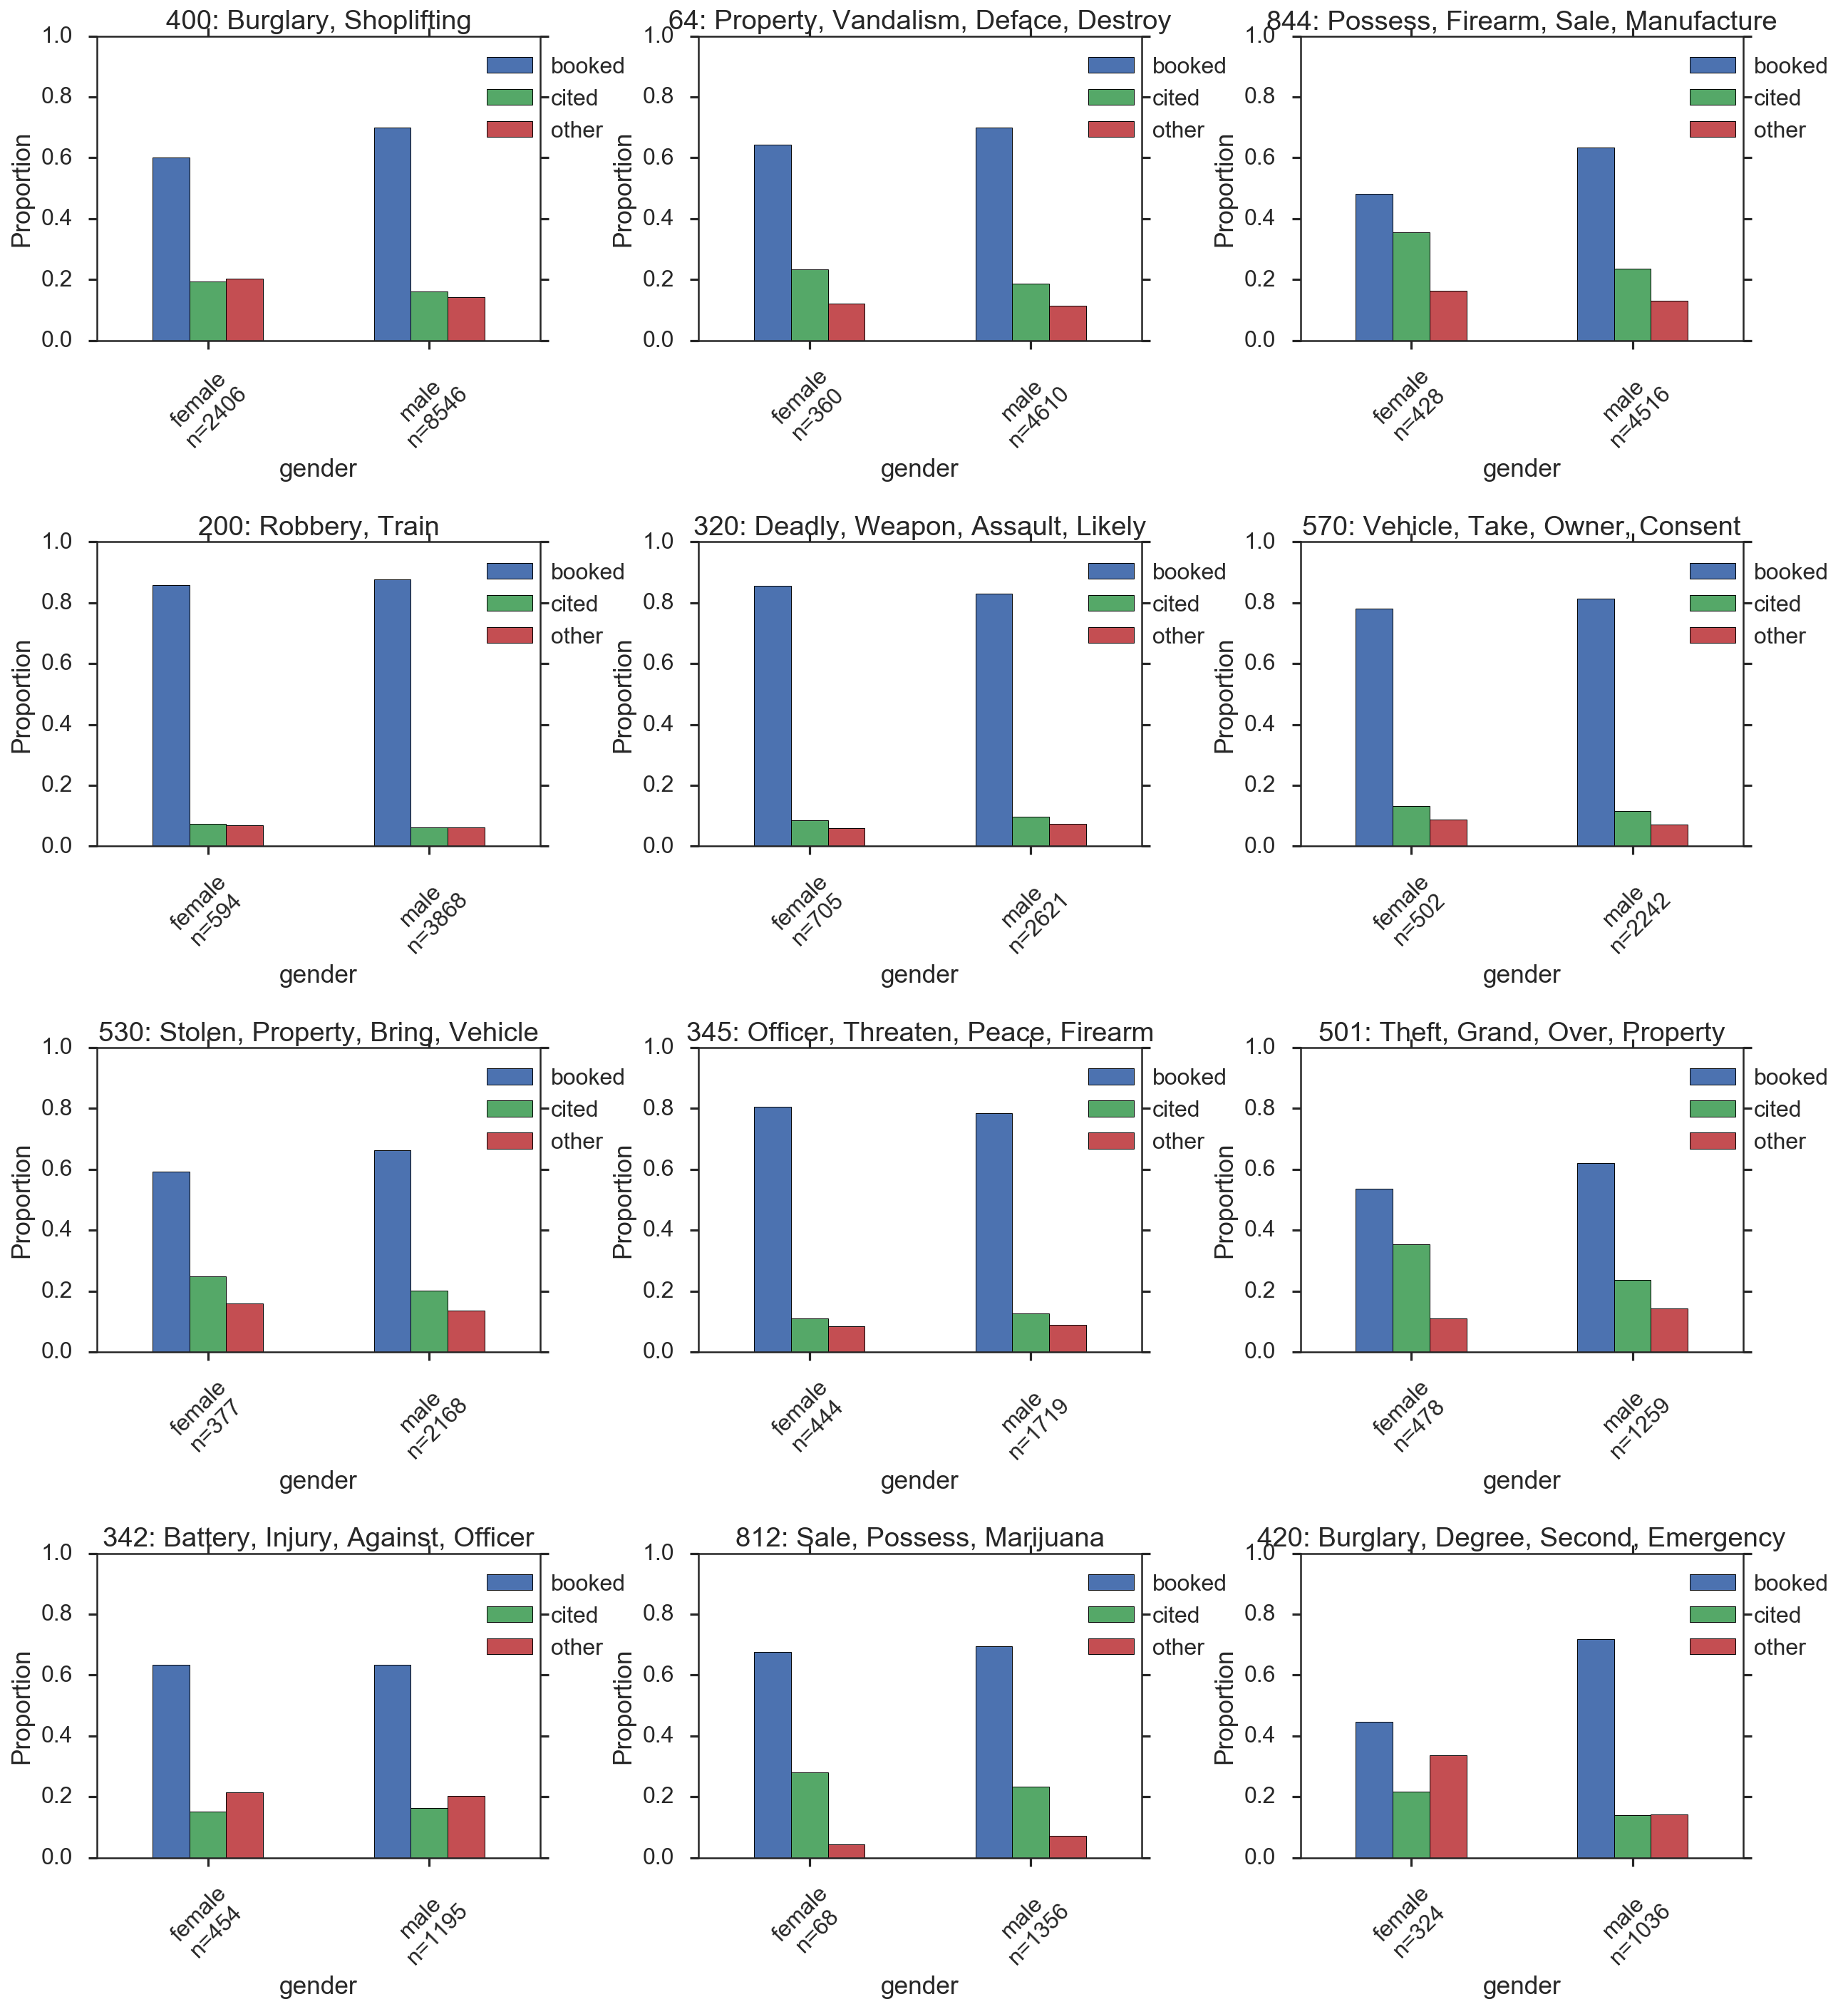

In [43]:
n_codes = 12

n_title_words=4

ncols=3
nrows=int(np.ceil(n_codes / ncols))

field = 'gender'

fig, (axes) = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 5*nrows))

for ax, code in zip(axes.flat, df_fel['bcs_offense_code'].value_counts().head(n_codes).index.tolist()):
    code_count = df_fel[df_fel['bcs_offense_code'] == code].groupby(by=[field, 'status_type']).size()
    race_count = df_fel[df_fel['bcs_offense_code'] == code].groupby(by=[field]).size()

    prop_race = pd.DataFrame(code_count / race_count).unstack()[0]
    #prop_race = prop_race.sort_values(by='booked', ascending=False)

    title_str = get_sorted_title_offense(df_off, code, n_title_words=n_title_words)

    prop_race.plot(ax=ax, kind='bar');
    
    xlabels = ['{r}\nn={n}'.format(r=x.get_text(), n=race_count[x.get_text()]) for x in ax.get_xticklabels()]
    ax.set_xticklabels(xlabels, rotation=45)
    
    ax.set_ylim((0, 1));
    ax.set_ylabel('Proportion');
    ax.set_title('{c}: {t}'.format(c=code,t=title_str));
    ax.legend(bbox_to_anchor=(1.24, 1.0));
    
fig.tight_layout();

# Logistic regression to start to understand importance of features for booked vs cited outcome

In [44]:
# cols = ['less_than_high_school',
#         'high_school_or_higher',
#         'bachelors_or_higher',
#         'per_capita_income',
#         'median_income',
#         'poverty_rate',
#         'employment_rate',
#         'unemployment_rate',
#         'population',
#        ]

# formula = 'booked ~ C(race_or_ethnicity) + C(gender) + {}'.format(' + '.join(cols))
# print(formula)
# mod = smf.logit(formula, df_fel)
# results = mod.fit()
# results.summary2()

In [45]:
# cols = ['less_than_high_school',
#         'high_school_or_higher',
#         'bachelors_or_higher',
#         'per_capita_income',
#         'median_income',
#         'poverty_rate',
#         'employment_rate',
#         'unemployment_rate',
#         'population',
#        ]

# formula = 'booked ~ C(race_or_ethnicity) + C(gender) + {}'.format(' + '.join(cols))

# results = cu.sm_logit(df_fel,
#                       f=formula,
#                       add_constant=True,
#                       #features=features,
#                       #categorical=categorical,
#                       #outcome=outcome,
#                      )


In [46]:
# # formula = 'booked ~ C(race_or_ethnicity) + C(gender) + {}'.format(' + '.join(cols))

# outcome = 'booked'
# # outcome = 'offense_level' # for felony vs misdemeanor, not working on this yet

# features = ['race_or_ethnicity',
#             'gender',
#             'bcs_offense_code',
#             #'bcs_summary_offence_code',
#             #'fbi_offense_code',
#             #'status_type',
#             'disposition',
#             'booked',
#             'less_than_high_school',
#             'high_school_or_higher',
#             'bachelors_or_higher',
#             #'per_capita_income', # not inclding because could be confounded with county population
#             'median_income',
#             'poverty_rate',
#             'employment_rate',
#             'unemployment_rate',
#             'population',
#            ]
# categorical = ['race_or_ethnicity',
#                'gender',
#                'bcs_offense_code',
#                #'bcs_summary_offence_code',
#                #'fbi_offense_code',
#                #'status_type',
#                'disposition',
#               ]

# results = cu.sm_logit(df_fel,
#                       #f=formula,
#                       subset=(df_fel['booked'] == 0) | (df_fel['booked'] == 1),
#                       add_constant=True,
#                       features=features,
#                       categorical=categorical,
#                       outcome=outcome,
#                       reg_method='l1',
#                       reg_alpha=1.0,
#                       missing='raise',
#                      )


In [136]:
# set up the formula

f = '''booked ~ 1
+ C(race_or_ethnicity)
+ C(gender)
+ C(race_or_ethnicity):C(gender)
+ less_than_high_school
+ high_school_or_higher
+ bachelors_or_higher
+ poverty_rate
+ employment_rate
+ unemployment_rate
+ I(median_income / 10000)
+ I(population / 10000)
+ I(prop_age_Adult * 100)
+ I(prop_gender_Male * 100)
+ I(prop_race_White * 100)
+ I(prop_race_Black * 100)
+ I(prop_race_Hispanic * 100)
'''

# + C(bcs_offense_code)

# + center(median_income)
# + center(population)

# + I(center(median_income) / 10000)
# + I(center(population) / 10000)

# + I(prop_race_Asian_PI * 100)
# + I(prop_race_Native_American * 100)
# + I(prop_race_Other * 100)

# + I(prop_age_Juvenile * 100)
# + I(prop_gender_Female * 100)

# + C(disposition)

# '+ I(per_capita_income / 10000)' # not inclding because could be confounded with county population

#  & (df_fel['bcs_offense_code'] == 300)

subset = ((df_fel['booked'] == 0) | (df_fel['booked'] == 1))

results = cu.sm_logit(df_fel,
                      f=f,
                      subset=subset,
                      #add_constant=True,
                      #features=features,
                      #categorical=categorical,
                      #outcome=outcome,
                      reg_method='l1',
                      reg_alpha=10.0,
                      missing='raise',
                      maxiter=100,
                     )

booked ~ 1
+ C(race_or_ethnicity)
+ C(gender)
+ C(race_or_ethnicity):C(gender)
+ less_than_high_school
+ high_school_or_higher
+ bachelors_or_higher
+ poverty_rate
+ employment_rate
+ unemployment_rate
+ I(median_income / 10000)
+ I(population / 10000)
+ I(prop_age_Adult * 100)
+ I(prop_gender_Male * 100)
+ I(prop_race_White * 100)
+ I(prop_race_Black * 100)
+ I(prop_race_Hispanic * 100)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.396849493195
            Iterations: 176
            Function evaluations: 189
            Gradient evaluations: 176


In [137]:
cu.print_sm_logit_results(results,
                          print_n=40,
                          print_p_limit=.05,
                          outcome_behavior='to be booked vs. cited and released at the time of arrest');

,0,1,2,3
0,Model:,Logit,Pseudo R-squared:,0.104
1,Dependent Variable:,booked,AIC:,45102.0532
2,Date:,2016-09-01 09:49,BIC:,45287.9698
3,No. Observations:,51698,Log-Likelihood:,-22530.
4,Df Model:,20,LL-Null:,-25147.
5,Df Residuals:,51677,LLR p-value:,0.0000
6,Converged:,True,Scale:,1.0000
7,No. Iterations:,176.0000,,


As feature increases, more likely to be booked vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
poverty_rate,0.08624,1.09007,0.00397,21.74384,0.00000,0.07846,0.09401
employment_rate,0.10031,1.10552,0.00654,15.33220,0.00000,0.08749,0.11314
I(prop_gender_Male * 100),0.19364,1.21366,0.01502,12.89074,0.00000,0.16420,0.22308
I(prop_race_White * 100),0.02521,1.02553,0.00339,7.43081,0.00000,0.01856,0.03186
bachelors_or_higher,0.03785,1.03858,0.00514,7.36685,0.00000,0.02778,0.04792
I(prop_race_Black * 100),0.03577,1.03641,0.00676,5.29079,0.00000,0.02252,0.04902
C(race_or_ethnicity)[T.Black],0.35846,1.43112,0.07556,4.74409,0.00000,0.21036,0.50655
C(gender)[T.male],0.35210,1.42205,0.07629,4.61550,0.00000,0.20258,0.50162
C(race_or_ethnicity)[T.suppressed],0.15679,1.16975,0.07634,2.05389,0.03999,0.00717,0.30641



As feature increases, less likely to be booked vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
I(median_income / 10000),-0.81040,2.24882,0.03394,-23.87445,0.00000,-0.87693,-0.74387
unemployment_rate,-0.27091,1.31115,0.01582,-17.12529,0.00000,-0.30191,-0.23990
high_school_or_higher,-0.13492,1.14445,0.00850,-15.88234,0.00000,-0.15157,-0.11827
I(prop_race_Hispanic * 100),-0.02868,1.02909,0.00297,-9.64762,0.00000,-0.03450,-0.02285
C(race_or_ethnicity)[T.White]:C(gender)[T.male],-0.37673,1.45751,0.06772,-5.56293,0.00000,-0.50946,-0.24400
C(race_or_ethnicity)[T.Other],-0.26393,1.30203,0.08876,-2.97352,0.00294,-0.43789,-0.08996


In [51]:
# found when including bcs_offense_code as categorical feature in logistic regression

# makes sense that murder-related offenses is highly associated with bookings!

# one way to get a summary of this offense code
code=300
n_title_words=6
print(get_sorted_title_offense(df_off, code, n_title_words=n_title_words))

# or view them all
df_off[(df_off['bcs_offense_code'] == code)].head()

Murder, Attempted, Degree, Second, First, Officer


,bcs_summary_offence_code,bcs_offense_code,hierarchy,offense_level,code_section,code_type,description,possible_sentence
1709,6,300,1750,F,664/187 (A),PC,ATTEMPTED MURDER:SECOND DEGREE ON PEACE OFFICER,LIFE W/O PAROLE
1710,6,300,2100,F,664/187 (A),PC,ATTEMPTED MURDER:PREMEDITATED,LIFE
1711,6,300,2900,F,664/187 (A),PC,ATTEMPTED MURDER,"5,7,9 YRS"
1712,6,300,2900,F,664/187 (A),PC,ATTEMPTED MURDER:FIRST DEGREE,"5,7,9 YRS"
1713,6,300,2900,F,664/187 (A),PC,ATTEMPTED MURDER:SECOND DEGREE,"5,7,9 YRS"


In [131]:
# found when including bcs_offense_code as categorical feature in logistic regression

code=410
n_title_words=6
print(get_sorted_title_offense(df_off, code, n_title_words=n_title_words))

df_off[(df_off['bcs_offense_code'] == code)].head()

Degree, Burglary, First


,bcs_summary_offence_code,bcs_offense_code,hierarchy,offense_level,code_section,code_type,description,possible_sentence
988,8,410,12900,F,459,PC,BURGLARY:FIRST DEGREE,"2,4,6 YRS"
994,8,410,12900,F,460 (A),PC,BURGLARY:FIRST DEGREE,"2,4,6 YRS"
997,8,410,12900,F,461.1,PC,BURGLARY:FIRST DEGREE,"2,4,6 YRS"


In [103]:
# found when including bcs_offense_code as categorical feature in logistic regression

code=993
n_title_words=6
print(get_sorted_title_offense(df_off, code, n_title_words=n_title_words))

# or view them all
df_off[(df_off['bcs_offense_code'] == code)].head()

Appear, Failure, Felony, Charge, Bench, Warrant


,bcs_summary_offence_code,bcs_offense_code,hierarchy,offense_level,code_section,code_type,description,possible_sentence
1754,25,993,72000,F,978.5,PC,BENCH WARRANT/FAILURE TO APPEAR ON FELONY CHARGE,N/A
1756,25,993,71700,F,979,PC,BENCH WARRANT/FAILURE TO APPEAR ON FELONY CHARGE,
1774,25,993,72000,F,1195,PC,FAILURE TO APPEAR AFTER RELEASE ON BAIL,
1785,25,993,71900,F,1320 (B),PC,FAILURE TO APPEAR ON FELONY CHARGE,"16 MO,2,3 YRS OR J"
1787,25,993,71600,F,1320.5,PC,FAILURE TO APPEAR ON FELONY CHARGE,"16 MO,2,3 YRS OR J"


In [49]:
# fig, ax = plt.subplots()

# field = 'high_school_or_higher'

# ax.plot(df_fel.loc[subset, :][field], cu.binary_jitter(df_fel.loc[subset, :]['booked'], .1), '.', alpha = .1)
# ax.plot(np.sort(df_fel.loc[subset, :][field]), results.predict()[np.argsort(df_fel.loc[subset, :][field])], lw = 2)
# ax.set_ylabel('Booked');
# ax.set_xlabel(field);

In [50]:
# field = 'high_school_or_higher'

# field = 'median_income'

# fig, ax = plt.subplots()

# df_fel.loc[subset & (df_fel['booked'] == 1), :][field].plot(ax=ax, kind='kde', label='Booked')
# df_fel.loc[subset & (df_fel['booked'] == 0), :][field].plot(ax=ax, kind='kde', label='Cited')

# ax.legend(loc='best');
# ax.set_xlabel(field);

# # ax.set_xlim(left=60, right=100);

In [52]:
# Run one logistic model for each of the top offense codes

f = '''booked ~ C(race_or_ethnicity) + C(gender)
+ C(race_or_ethnicity):C(gender)
+ less_than_high_school + high_school_or_higher + bachelors_or_higher
+ poverty_rate + employment_rate + unemployment_rate
+ I(median_income / 10000)
+ I(population / 10000)
+ I(prop_age_Adult * 100)
+ I(prop_gender_Male * 100)
+ I(prop_race_White * 100)
'''
# + C(bcs_offense_code)

# + I(prop_age_Juvenile * 100)
# + I(prop_gender_Female * 100)
# + I(prop_race_Hispanic * 100)
# + I(prop_race_Black * 100)
# + I(prop_race_Asian_PI * 100)
# + I(prop_race_Native_American * 100)
# + I(prop_race_Other * 100)

# + C(disposition)

# '+ I(per_capita_income/10000)' # not inclding because could be confounded with county population

n_codes=12
n_title_words=5

for code in df_fel['bcs_offense_code'].value_counts().index[:n_codes].tolist():
    title_str = get_sorted_title_offense(df_off, code, n_title_words=n_title_words)
    print('========================================')
    print('{c}: {t}'.format(c=code, t=title_str))
    print('========================================')
    
    subset = ((df_fel['booked'] == 0) | (df_fel['booked'] == 1)) & (df_fel['bcs_offense_code'] == code)
    
    results = cu.sm_logit(df_fel,
                          f=f,
                          subset=subset,
                          #add_constant=True,
                          #features=features,
                          #categorical=categorical,
                          #outcome=outcome,
                          reg_method='l1',
                          reg_alpha=0.1,
                          missing='raise',
                         )

    cu.print_sm_logit_results(results,
                              print_n=40,
                              print_p_limit=.05,
                              outcome_behavior='to be booked for {t} vs. cited and released at the time of arrest'.format(t=title_str));

400: Burglary, Shoplifting
booked ~ C(race_or_ethnicity) + C(gender)
+ C(race_or_ethnicity):C(gender)
+ less_than_high_school + high_school_or_higher + bachelors_or_higher
+ poverty_rate + employment_rate + unemployment_rate
+ I(median_income / 10000)
+ I(population / 10000)
+ I(prop_age_Adult * 100)
+ I(prop_gender_Male * 100)
+ I(prop_race_White * 100)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.388233607261
            Iterations: 458
            Function evaluations: 469
            Gradient evaluations: 458
QC check did not pass for 5 out of 23 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


,0,1,2,3
0,Model:,Logit,Pseudo R-squared:,0.221
1,Dependent Variable:,booked,AIC:,7228.9456
2,Date:,2016-08-31 17:35,BIC:,7393.0028
3,No. Observations:,9255,Log-Likelihood:,-3591.5
4,Df Model:,22,LL-Null:,-4611.8
5,Df Residuals:,9232,LLR p-value:,0.0000
6,Converged:,True,Scale:,1.0000
7,No. Iterations:,458.0000,,


As feature increases, more likely to be booked for Burglary, Shoplifting vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
I(population / 10000),0.00257,1.00258,0.00020,12.79374,0.00000,0.00218,0.00297
poverty_rate,0.08058,1.08392,0.01016,7.92793,0.00000,0.06066,0.10050
Intercept,11.86359,142001.74241,3.63728,3.26166,0.00111,4.73465,18.99254
bachelors_or_higher,0.03076,1.03124,0.01195,2.57360,0.01006,0.00733,0.05419
I(prop_race_White * 100),0.01334,1.01343,0.00543,2.45930,0.01392,0.00271,0.02398



As feature increases, less likely to be booked for Burglary, Shoplifting vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
I(median_income / 10000),-0.88188,2.41545,0.08777,-10.04776,0.00000,-1.05391,-0.70986
unemployment_rate,-0.35660,1.42846,0.05190,-6.87067,0.00000,-0.45833,-0.25487
less_than_high_school,-0.06981,1.07231,0.01662,-4.19947,0.00003,-0.10240,-0.03723
high_school_or_higher,-0.06450,1.06662,0.01752,-3.68202,0.00023,-0.09883,-0.03017
C(race_or_ethnicity)[T.Hispanic],-0.75565,2.12900,0.32261,-2.34230,0.01917,-1.38796,-0.12335


64: Property, Vandalism, Deface, Destroy, Prior
booked ~ C(race_or_ethnicity) + C(gender)
+ C(race_or_ethnicity):C(gender)
+ less_than_high_school + high_school_or_higher + bachelors_or_higher
+ poverty_rate + employment_rate + unemployment_rate
+ I(median_income / 10000)
+ I(population / 10000)
+ I(prop_age_Adult * 100)
+ I(prop_gender_Male * 100)
+ I(prop_race_White * 100)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.393633135061
            Iterations: 464
            Function evaluations: 477
            Gradient evaluations: 464
QC check did not pass for 2 out of 23 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


,0,1,2,3
0,Model:,Logit,Pseudo R-squared:,0.243
1,Dependent Variable:,booked,AIC:,3499.8399
2,Date:,2016-08-31 17:35,BIC:,3646.7690
3,No. Observations:,4395,Log-Likelihood:,-1726.9
4,Df Model:,22,LL-Null:,-2281.2
5,Df Residuals:,4372,LLR p-value:,1.4171e-220
6,Converged:,True,Scale:,1.0000
7,No. Iterations:,464.0000,,


As feature increases, more likely to be booked for Property, Vandalism, Deface, Destroy, Prior vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
I(population / 10000),0.00206,1.00206,0.00028,7.24963,0.00000,0.00150,0.00261
I(prop_race_White * 100),0.04242,1.04334,0.00820,5.17566,0.00000,0.02636,0.05849
Intercept,21.30416,1787639398.14559,6.53010,3.26245,0.00110,8.50539,34.10293
poverty_rate,0.04547,1.04652,0.01705,2.66743,0.00764,0.01206,0.07889
bachelors_or_higher,0.05214,1.05353,0.02065,2.52480,0.01158,0.01167,0.09262



As feature increases, less likely to be booked for Property, Vandalism, Deface, Destroy, Prior vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
high_school_or_higher,-0.24395,1.27628,0.02761,-8.83469,0.00000,-0.29807,-0.18983
unemployment_rate,-0.34216,1.40799,0.07831,-4.36915,0.00001,-0.49566,-0.18867
I(median_income / 10000),-0.48156,1.61859,0.13004,-3.70324,0.00021,-0.73642,-0.22669
less_than_high_school,-0.10015,1.10534,0.02757,-3.63251,0.00028,-0.15419,-0.04611
C(race_or_ethnicity)[T.Other],-3.00912,20.26964,1.47967,-2.03364,0.04199,-5.90923,-0.10902


844: Possess, Firearm, Sale, Manufacture, Weapon
booked ~ C(race_or_ethnicity) + C(gender)
+ C(race_or_ethnicity):C(gender)
+ less_than_high_school + high_school_or_higher + bachelors_or_higher
+ poverty_rate + employment_rate + unemployment_rate
+ I(median_income / 10000)
+ I(population / 10000)
+ I(prop_age_Adult * 100)
+ I(prop_gender_Male * 100)
+ I(prop_race_White * 100)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.440634076631
            Iterations: 401
            Function evaluations: 414
            Gradient evaluations: 401
QC check did not pass for 7 out of 23 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


,0,1,2,3
0,Model:,Logit,Pseudo R-squared:,0.262
1,Dependent Variable:,booked,AIC:,3817.5139
2,Date:,2016-08-31 17:35,BIC:,3963.8547
3,No. Observations:,4284,Log-Likelihood:,-1885.8
4,Df Model:,22,LL-Null:,-2555.6
5,Df Residuals:,4261,LLR p-value:,6.1493e-270
6,Converged:,True,Scale:,1.0000
7,No. Iterations:,401.0000,,


As feature increases, more likely to be booked for Possess, Firearm, Sale, Manufacture, Weapon vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
I(population / 10000),0.00352,1.00352,0.00039,9.05461,0.00000,0.00276,0.00428
poverty_rate,0.07409,1.07690,0.01524,4.86007,0.00000,0.04421,0.10396
bachelors_or_higher,0.07893,1.08213,0.01831,4.31043,0.00002,0.04304,0.11482
I(prop_race_White * 100),0.02248,1.02273,0.00772,2.91303,0.00358,0.00735,0.03760
Intercept,14.85465,2826771.71143,6.64997,2.23379,0.02550,1.82094,27.88835



As feature increases, less likely to be booked for Possess, Firearm, Sale, Manufacture, Weapon vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
I(median_income / 10000),-0.91929,2.50750,0.11991,-7.66663,0.00000,-1.15430,-0.68427
high_school_or_higher,-0.11750,1.12468,0.02666,-4.40765,0.00001,-0.16975,-0.06525
unemployment_rate,-0.26387,1.30195,0.06899,-3.82452,0.00013,-0.39909,-0.12864


200: Robbery, Train
booked ~ C(race_or_ethnicity) + C(gender)
+ C(race_or_ethnicity):C(gender)
+ less_than_high_school + high_school_or_higher + bachelors_or_higher
+ poverty_rate + employment_rate + unemployment_rate
+ I(median_income / 10000)
+ I(population / 10000)
+ I(prop_age_Adult * 100)
+ I(prop_gender_Male * 100)
+ I(prop_race_White * 100)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.202727733418
            Iterations: 396
            Function evaluations: 410
            Gradient evaluations: 396


,0,1,2,3
0,Model:,Logit,Pseudo R-squared:,-43.360
1,Dependent Variable:,booked,AIC:,91896.5677
2,Date:,2016-08-31 17:35,BIC:,92004.3271
3,No. Observations:,4183,Log-Likelihood:,-45931.
4,Df Model:,16,LL-Null:,-1035.4
5,Df Residuals:,4166,LLR p-value:,1.0000
6,Converged:,True,Scale:,1.0000
7,No. Iterations:,396.0000,,


As feature increases, more likely to be booked for Robbery, Train vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]



As feature increases, less likely to be booked for Robbery, Train vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]


320: Deadly, Weapon, Assault, Likely, Transportation
booked ~ C(race_or_ethnicity) + C(gender)
+ C(race_or_ethnicity):C(gender)
+ less_than_high_school + high_school_or_higher + bachelors_or_higher
+ poverty_rate + employment_rate + unemployment_rate
+ I(median_income / 10000)
+ I(population / 10000)
+ I(prop_age_Adult * 100)
+ I(prop_gender_Male * 100)
+ I(prop_race_White * 100)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.269651624953
            Iterations: 313
            Function evaluations: 324
            Gradient evaluations: 313
QC check did not pass for 2 out of 23 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


,0,1,2,3
0,Model:,Logit,Pseudo R-squared:,0.185
1,Dependent Variable:,booked,AIC:,1712.3387
2,Date:,2016-08-31 17:35,BIC:,1851.1799
3,No. Observations:,3092,Log-Likelihood:,-833.17
4,Df Model:,22,LL-Null:,-1022.2
5,Df Residuals:,3069,LLR p-value:,1.3793e-66
6,Converged:,True,Scale:,1.0000
7,No. Iterations:,313.0000,,


As feature increases, more likely to be booked for Deadly, Weapon, Assault, Likely, Transportation vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
poverty_rate,0.09096,1.09522,0.02375,3.83032,0.00013,0.04442,0.13750
I(population / 10000),0.00183,1.00183,0.00057,3.21181,0.00132,0.00071,0.00295
I(prop_age_Adult * 100),0.16376,1.17793,0.05474,2.99183,0.00277,0.05648,0.27104



As feature increases, less likely to be booked for Deadly, Weapon, Assault, Likely, Transportation vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
I(median_income / 10000),-0.84213,2.32131,0.19180,-4.39068,0.00001,-1.21805,-0.46621
high_school_or_higher,-0.11136,1.11780,0.03941,-2.82598,0.00471,-0.18859,-0.03413
unemployment_rate,-0.29201,1.33911,0.10694,-2.73047,0.00632,-0.50162,-0.08240


570: Vehicle, Take, Owner, Consent, Emergency
booked ~ C(race_or_ethnicity) + C(gender)
+ C(race_or_ethnicity):C(gender)
+ less_than_high_school + high_school_or_higher + bachelors_or_higher
+ poverty_rate + employment_rate + unemployment_rate
+ I(median_income / 10000)
+ I(population / 10000)
+ I(prop_age_Adult * 100)
+ I(prop_gender_Male * 100)
+ I(prop_race_White * 100)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.321886957854
            Iterations: 355
            Function evaluations: 365
            Gradient evaluations: 355
QC check did not pass for 5 out of 23 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


,0,1,2,3
0,Model:,Logit,Pseudo R-squared:,0.161
1,Dependent Variable:,booked,AIC:,1679.3329
2,Date:,2016-08-31 17:35,BIC:,1813.6601
3,No. Observations:,2541,Log-Likelihood:,-816.67
4,Df Model:,22,LL-Null:,-973.54
5,Df Residuals:,2518,LLR p-value:,1.9629e-53
6,Converged:,True,Scale:,1.0000
7,No. Iterations:,355.0000,,


As feature increases, more likely to be booked for Vehicle, Take, Owner, Consent, Emergency vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
I(population / 10000),0.00383,1.00384,0.00070,5.45503,0.00000,0.00245,0.00520



As feature increases, less likely to be booked for Vehicle, Take, Owner, Consent, Emergency vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
I(median_income / 10000),-0.81439,2.25779,0.17310,-4.70464,0.00000,-1.15366,-0.47511


530: Stolen, Property, Bring, Vehicle, Determine
booked ~ C(race_or_ethnicity) + C(gender)
+ C(race_or_ethnicity):C(gender)
+ less_than_high_school + high_school_or_higher + bachelors_or_higher
+ poverty_rate + employment_rate + unemployment_rate
+ I(median_income / 10000)
+ I(population / 10000)
+ I(prop_age_Adult * 100)
+ I(prop_gender_Male * 100)
+ I(prop_race_White * 100)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.457542545681
            Iterations: 294
            Function evaluations: 308
            Gradient evaluations: 294
QC check did not pass for 5 out of 23 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


,0,1,2,3
0,Model:,Logit,Pseudo R-squared:,0.174
1,Dependent Variable:,booked,AIC:,2046.7610
2,Date:,2016-08-31 17:35,BIC:,2177.6480
3,No. Observations:,2188,Log-Likelihood:,-1000.4
4,Df Model:,22,LL-Null:,-1211.4
5,Df Residuals:,2165,LLR p-value:,1.1943e-75
6,Converged:,True,Scale:,1.0000
7,No. Iterations:,294.0000,,


As feature increases, more likely to be booked for Stolen, Property, Bring, Vehicle, Determine vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
poverty_rate,0.12177,1.12949,0.01819,6.69403,0.00000,0.08612,0.15742
I(population / 10000),0.00237,1.00237,0.00050,4.69462,0.00000,0.00138,0.00336
I(prop_race_White * 100),0.02522,1.02555,0.00869,2.90406,0.00368,0.00820,0.04225
I(prop_gender_Male * 100),0.16891,1.18402,0.08211,2.05720,0.03967,0.00798,0.32984
employment_rate,0.07616,1.07913,0.03718,2.04810,0.04055,0.00328,0.14904



As feature increases, less likely to be booked for Stolen, Property, Bring, Vehicle, Determine vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
I(median_income / 10000),-0.97594,2.65367,0.15539,-6.28070,0.00000,-1.28050,-0.67139
unemployment_rate,-0.36223,1.43653,0.08594,-4.21481,0.00002,-0.53068,-0.19379
high_school_or_higher,-0.08695,1.09085,0.03037,-2.86335,0.00419,-0.14647,-0.02743


345: Officer, Threaten, Peace, Firearm, Remove
booked ~ C(race_or_ethnicity) + C(gender)
+ C(race_or_ethnicity):C(gender)
+ less_than_high_school + high_school_or_higher + bachelors_or_higher
+ poverty_rate + employment_rate + unemployment_rate
+ I(median_income / 10000)
+ I(population / 10000)
+ I(prop_age_Adult * 100)
+ I(prop_gender_Male * 100)
+ I(prop_race_White * 100)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.327147194257
            Iterations: 416
            Function evaluations: 427
            Gradient evaluations: 416
QC check did not pass for 3 out of 23 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


,0,1,2,3
0,Model:,Logit,Pseudo R-squared:,0.175
1,Dependent Variable:,booked,AIC:,1329.8981
2,Date:,2016-08-31 17:35,BIC:,1458.4062
3,No. Observations:,1973,Log-Likelihood:,-641.95
4,Df Model:,22,LL-Null:,-778.36
5,Df Residuals:,1950,LLR p-value:,3.8024e-45
6,Converged:,True,Scale:,1.0000
7,No. Iterations:,416.0000,,


As feature increases, more likely to be booked for Officer, Threaten, Peace, Firearm, Remove vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
I(population / 10000),0.00267,1.00267,0.00060,4.48282,0.00001,0.00150,0.00384
Intercept,28.88478,3503478565647.69189,9.85701,2.93038,0.00339,9.56539,48.20416
I(prop_race_White * 100),0.03912,1.03989,0.01339,2.92190,0.00348,0.01288,0.06536



As feature increases, less likely to be booked for Officer, Threaten, Peace, Firearm, Remove vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
unemployment_rate,-0.60562,1.83238,0.12205,-4.96216,0.00000,-0.84482,-0.36641
high_school_or_higher,-0.20070,1.22226,0.04274,-4.69577,0.00000,-0.28447,-0.11693
I(median_income / 10000),-0.44386,1.55871,0.19173,-2.31503,0.02061,-0.81964,-0.06808


501: Theft, Grand, Over, Property, Money
booked ~ C(race_or_ethnicity) + C(gender)
+ C(race_or_ethnicity):C(gender)
+ less_than_high_school + high_school_or_higher + bachelors_or_higher
+ poverty_rate + employment_rate + unemployment_rate
+ I(median_income / 10000)
+ I(population / 10000)
+ I(prop_age_Adult * 100)
+ I(prop_gender_Male * 100)
+ I(prop_race_White * 100)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.457098893055
            Iterations: 273
            Function evaluations: 285
            Gradient evaluations: 273
QC check did not pass for 2 out of 23 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


,0,1,2,3
0,Model:,Logit,Pseudo R-squared:,0.264
1,Dependent Variable:,booked,AIC:,1419.0035
2,Date:,2016-08-31 17:35,BIC:,1541.2841
3,No. Observations:,1505,Log-Likelihood:,-686.50
4,Df Model:,22,LL-Null:,-932.90
5,Df Residuals:,1482,LLR p-value:,2.3105e-90
6,Converged:,True,Scale:,1.0000
7,No. Iterations:,273.0000,,


As feature increases, more likely to be booked for Theft, Grand, Over, Property, Money vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
poverty_rate,0.14334,1.15412,0.02825,5.07375,0.00000,0.08797,0.19871
employment_rate,0.19145,1.21101,0.06183,3.09652,0.00196,0.07027,0.31263



As feature increases, less likely to be booked for Theft, Grand, Over, Property, Money vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
I(median_income / 10000),-1.48655,4.42182,0.20680,-7.18829,0.00000,-1.89188,-1.08123
unemployment_rate,-0.55639,1.74437,0.12655,-4.39649,0.00001,-0.80443,-0.30835


342: Battery, Injury, Against, Officer, Emergency
booked ~ C(race_or_ethnicity) + C(gender)
+ C(race_or_ethnicity):C(gender)
+ less_than_high_school + high_school_or_higher + bachelors_or_higher
+ poverty_rate + employment_rate + unemployment_rate
+ I(median_income / 10000)
+ I(population / 10000)
+ I(prop_age_Adult * 100)
+ I(prop_gender_Male * 100)
+ I(prop_race_White * 100)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.436402842202
            Iterations: 278
            Function evaluations: 292
            Gradient evaluations: 278
QC check did not pass for 2 out of 23 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


,0,1,2,3
0,Model:,Logit,Pseudo R-squared:,0.135
1,Dependent Variable:,booked,AIC:,1185.1445
2,Date:,2016-08-31 17:35,BIC:,1304.2335
3,No. Observations:,1310,Log-Likelihood:,-569.57
4,Df Model:,22,LL-Null:,-658.29
5,Df Residuals:,1287,LLR p-value:,2.7662e-26
6,Converged:,True,Scale:,1.0000
7,No. Iterations:,278.0000,,


As feature increases, more likely to be booked for Battery, Injury, Against, Officer, Emergency vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
bachelors_or_higher,0.10553,1.11130,0.02818,3.74490,0.00018,0.05030,0.16076
I(prop_race_White * 100),0.02582,1.02616,0.01287,2.00611,0.04484,0.00059,0.05104



As feature increases, less likely to be booked for Battery, Injury, Against, Officer, Emergency vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
unemployment_rate,-0.48435,1.62313,0.13094,-3.69914,0.00022,-0.74099,-0.22772
high_school_or_higher,-0.17054,1.18595,0.04853,-3.51421,0.00044,-0.26566,-0.07543


812: Sale, Possess, Marijuana
booked ~ C(race_or_ethnicity) + C(gender)
+ C(race_or_ethnicity):C(gender)
+ less_than_high_school + high_school_or_higher + bachelors_or_higher
+ poverty_rate + employment_rate + unemployment_rate
+ I(median_income / 10000)
+ I(population / 10000)
+ I(prop_age_Adult * 100)
+ I(prop_gender_Male * 100)
+ I(prop_race_White * 100)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4532621584
            Iterations: 298
            Function evaluations: 310
            Gradient evaluations: 298
QC check did not pass for 1 out of 23 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


,0,1,2,3
0,Model:,Logit,Pseudo R-squared:,0.200
1,Dependent Variable:,booked,AIC:,1242.2943
2,Date:,2016-08-31 17:35,BIC:,1361.6105
3,No. Observations:,1323,Log-Likelihood:,-598.15
4,Df Model:,22,LL-Null:,-747.52
5,Df Residuals:,1300,LLR p-value:,2.1957e-50
6,Converged:,True,Scale:,1.0000
7,No. Iterations:,298.0000,,


As feature increases, more likely to be booked for Sale, Possess, Marijuana vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
I(population / 10000),0.00216,1.00216,0.00050,4.33552,0.00001,0.00118,0.00313
poverty_rate,0.06983,1.07232,0.02456,2.84311,0.00447,0.02169,0.11796
bachelors_or_higher,0.05940,1.06120,0.02658,2.23510,0.02541,0.00731,0.11148



As feature increases, less likely to be booked for Sale, Possess, Marijuana vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
I(median_income / 10000),-0.96418,2.62263,0.20775,-4.64105,0.00000,-1.37136,-0.55699
unemployment_rate,-0.31561,1.37110,0.13068,-2.41524,0.01573,-0.57173,-0.05949


420: Burglary, Degree, Second, Emergency, State
booked ~ C(race_or_ethnicity) + C(gender)
+ C(race_or_ethnicity):C(gender)
+ less_than_high_school + high_school_or_higher + bachelors_or_higher
+ poverty_rate + employment_rate + unemployment_rate
+ I(median_income / 10000)
+ I(population / 10000)
+ I(prop_age_Adult * 100)
+ I(prop_gender_Male * 100)
+ I(prop_race_White * 100)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.401167680668
            Iterations: 309
            Function evaluations: 320
            Gradient evaluations: 309
QC check did not pass for 6 out of 23 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


,0,1,2,3
0,Model:,Logit,Pseudo R-squared:,0.192
1,Dependent Variable:,booked,AIC:,925.6910
2,Date:,2016-08-31 17:35,BIC:,1040.8658
3,No. Observations:,1105,Log-Likelihood:,-439.85
4,Df Model:,22,LL-Null:,-544.52
5,Df Residuals:,1082,LLR p-value:,1.6614e-32
6,Converged:,True,Scale:,1.0000
7,No. Iterations:,309.0000,,


As feature increases, more likely to be booked for Burglary, Degree, Second, Emergency, State vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
poverty_rate,0.14800,1.15951,0.03906,3.78942,0.00015,0.07145,0.22455
I(prop_gender_Male * 100),0.62135,1.86145,0.19401,3.20267,0.00136,0.24110,1.00161
bachelors_or_higher,0.18364,1.20158,0.06956,2.63995,0.00829,0.04730,0.31997



As feature increases, less likely to be booked for Burglary, Degree, Second, Emergency, State vs. cited and released at the time of arrest:


,Coef.,Odds Ratio,Std.Err.,z,P>|z|,[0.025,0.975]
I(median_income / 10000),-1.09552,2.99072,0.34374,-3.18705,0.00144,-1.76923,-0.42180


In [86]:
# field = 'median_income'
# # field='prop_gender_Male'
# field='poverty_rate'
# bins=6

# resids = cu.bin_residuals(results.resid_response,
#                                df_fel.loc[subset, :][field],
#                                bins)
# plt.figure(figsize = (6, 5))
# plt.ylabel('Residual (bin avg.)')
# plt.xlabel('{} (bin avg.)'.format(field))
# cu.plot_binned_residuals(resids)


/Users/mattmollison/src/python/classify_utils.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_pos[log_col] = df_pos[log_col].apply(lambda x: np.log(x))
/Users/mattmollison/src/python/classify_utils.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_neg[log_col] = df_neg[log_col].apply(lambda x: np.log(x))


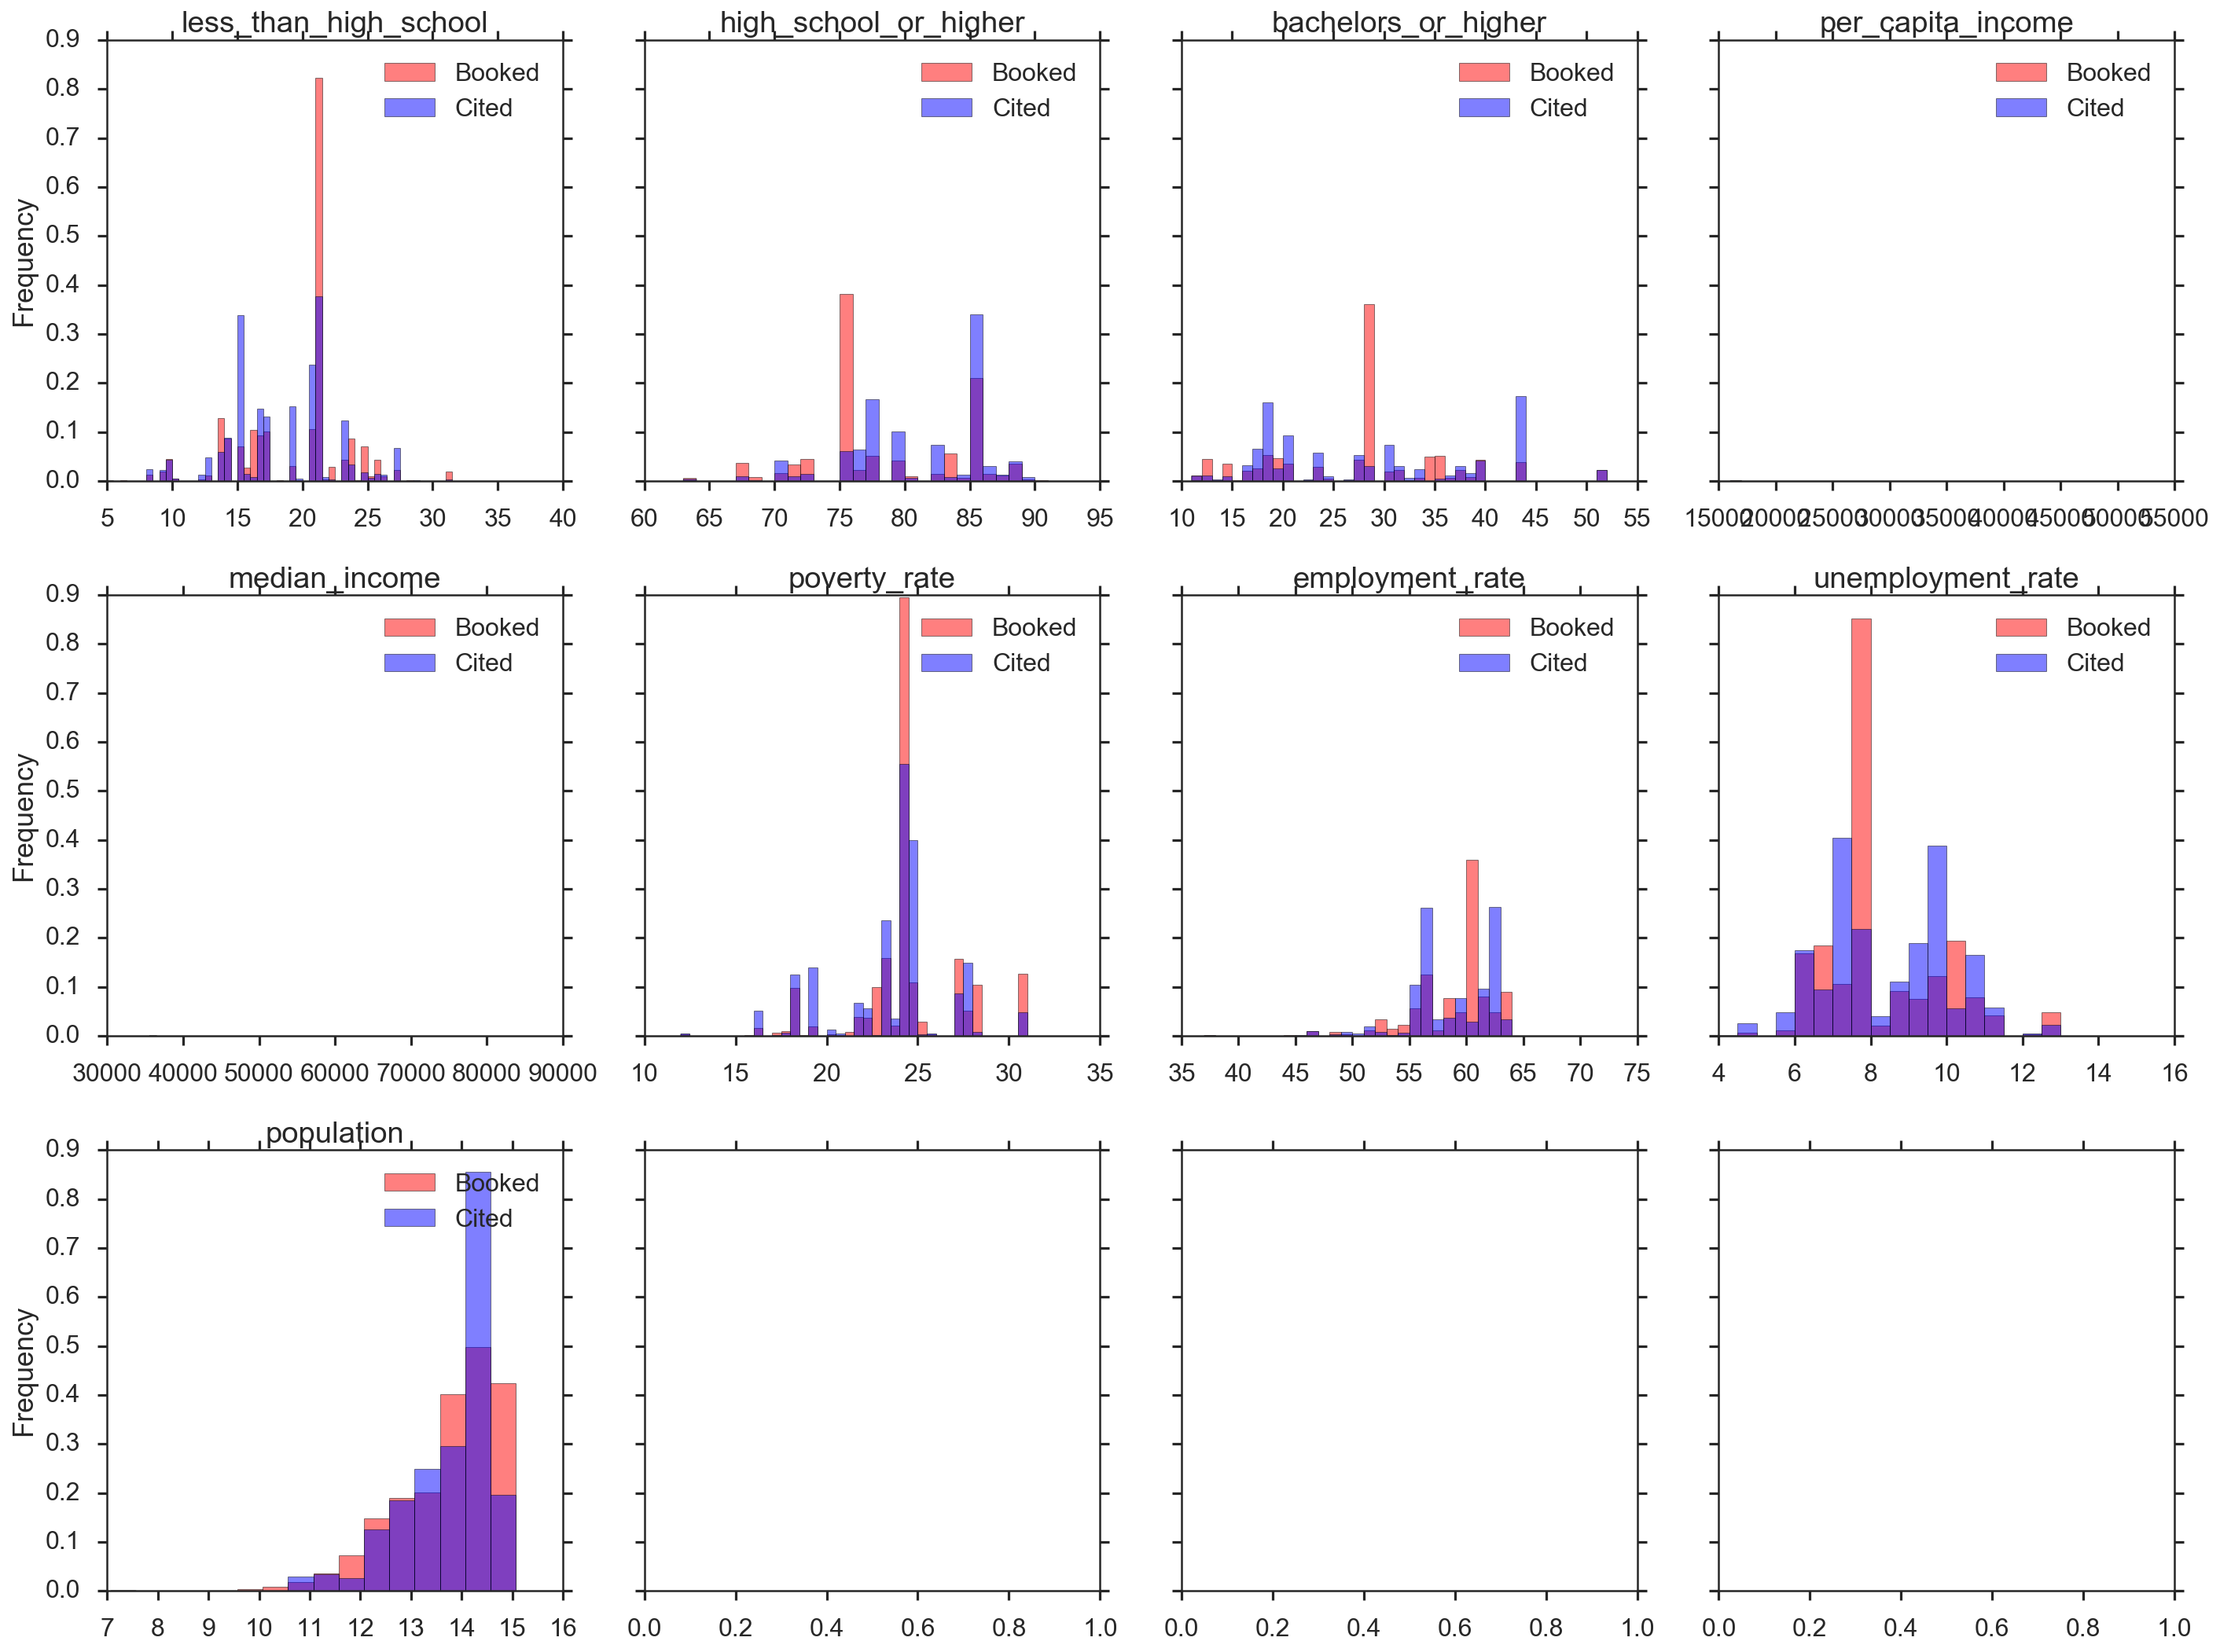

In [53]:
fields = ['less_than_high_school',
        'high_school_or_higher',
        'bachelors_or_higher',
        'per_capita_income',
        'median_income',
        'poverty_rate',
        'employment_rate',
        'unemployment_rate',
        'population',
         ]
cu.plot_hist(df_fel[(df_fel['booked'] == 1)], df_fel[(df_fel['booked'] == 0)],
             results=fields,
             normed=True,
             pos_str='Booked',
             neg_str='Cited',
             log_trans=['population']
            );

In [54]:
# #'summary_offense_level', 'offense_level',

# features = ['race_or_ethnicity', 'gender',
#             #'bcs_offense_code',
#             'bcs_summary_offence_code',
#             #'fbi_offense_code',
#             #'status_type',
#             #'disposition',
#             'booked',
#            ]
# categorical = ['race_or_ethnicity', 'gender',
#                #'bcs_offense_code',
#                'bcs_summary_offence_code',
#                #'fbi_offense_code',
#                #'status_type',
#                #'disposition',
#               ]
# # outcome = 'offense_level'
# outcome = 'booked'

# results = cu.sm_logit(df_fel,
#                       add_constant=True,
#                       features=features,
#                       outcome=outcome,
#                       categorical=categorical)


In [55]:
# cu.print_sm_logit_results(results, print_p_limit=.05);

In [56]:
# cu.classify(X_train, X_test, y_train, y_test, classifier='lr')

In [57]:
# for col in df_fel.columns:
#     print('\n',df_fel[col].value_counts().head(10))

In [58]:
# from sklearn.ensemble import RandomForestClassifier